# Test 2 on TESS data 

Test 2 on TESS data aims to examine the performance of a random forest without considering the follow-up characteristics

In [1]:
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

# import custom modules
from data_processing.distribution import (plot_class_distribution, plot_feature_importances,
                                          plot_scatter_feature_distributions, 
                                          plot_hist_feature_distributions,
                                          plot_hist_feature_distributions_0_1,
                                          compute_train_0_1)
from data_processing.data_analysis import (compute_all_columns_nan, print_nan_numbers_for_features,
                                           threshold_delete_nan)
from data_processing.data_balancing import smote_oversampling
from data_processing.data_scaling import plot_top_7_difference, data_scaling_normalization
from data_processing.features_prosessing import remove_non_numeric_columns, rows_id_nan, remove_nan_label
from data_processing.knn_imputer import k_nearest_neighbors_imputer
from data_processing.replace_disposition import replace_label
from dimensionality_reduction.features_selection import compute_feature_importance, feature_selection_rfc
from model_selection.grid_search import grid_search_param_optimization
from utils.mission import Mission
from utils.util import print_count_nan, print_feature_importance, plot_confusion_matrix

# Read Data

read the csv file taken from:
1. TESS: ExoFOP https://exofop.ipac.caltech.edu/tess/view_toi.php

In [2]:
tess_data = pd.read_csv('../data/raw_data/tess_exofop.csv')
print('Shape of ExoFOP TESS data:', tess_data.shape)
_ = print_count_nan(data=tess_data, name='TESS')

Shape of ExoFOP TESS data: (6977, 62)
Number of not a numbers values in TESS: 38201 out of 432574: 8.83%


# Replace Label

In the data initially there is an disposition that includes 3 or more classes.

TESS: Disposizione TFOPWG
1. APC = Candidato Planetario Ambiguo
2. CP = Pianeta Confermato
3. FA = Falso Allarme
4. FP = Falso Positivo
5. KP = Pianeta Conosciuto
6. PC = Candidato Planetario

with the aim of making a binary classifier we use the following procedure to replace:
1. KP, CP, PC with the label: 1
2. APC, FA, FP with the label: 0

NASA Exoplanet Archive documentation: https://exoplanetarchive.ipac.caltech.edu/docs/API_TOI_columns.html 

ExoFOP documentation: https://exofop.ipac.caltech.edu/tess/tsm.php

In [3]:
tess_data = replace_label(data=tess_data, mission=Mission.TESS)
print('Shape of TESS data: ', tess_data.shape)

Shape of TESS data:  (6977, 62)


# Feature and Label Processing

The Kepler and TESS data have different features, so we want to find an intersection between the two sets of data. To do this, we perform several operations:

1. Removing non-numeric features
2. Removing of identifying characteristics
3. Identifying the labels (X_train, y_train)
4. Removing NaN in y_train and correspondingly also the X_train rows (if there are)

In [4]:
tess_data, non_numeric_columns = remove_non_numeric_columns(df=tess_data)
print('Non numric columns removed:', non_numeric_columns)

Non numric columns removed: ['Previous CTOI', 'TESS Disposition', 'Source', 'Detection', 'RA', 'Dec', 'Sectors', 'Date TOI Alerted (UTC)', 'Date TOI Updated (UTC)', 'Date Modified', 'Comments']


In [5]:
col = ['TOI', 'TIC ID', 'Pipeline Signal ID', 'Imaging Observations',
       'Spectroscopy Observations', 'Time Series Observations', 'SG3',
       'SG5', 'SG2', 'SG4', 'Master', 'SG1B', 'SG1A', 'Epoch (BJD)', 'Epoch (BJD) err']
tess_data = tess_data.drop(columns=col, axis=1)

In [6]:
y_train = tess_data['TFOPWG Disposition']
tess_data = tess_data.drop(columns='TFOPWG Disposition')
X_train = tess_data

In [7]:
print('Shape of X_test_tess data: ', X_train.shape)
print('Shape of y_test_tess data: ', y_train.shape)
_ = print_count_nan(data=tess_data, name='TESS')

Shape of X_test_tess data:  (6977, 35)
Shape of y_test_tess data:  (6977,)
Number of not a numbers values in TESS: 31406 out of 244195: 12.86%


In [8]:
_ = print_count_nan(data=y_train, name='y_train')

Number of not a numbers values in y_train: 98 out of 6977: 1.40%


In this case there are 98 not a number in the labels so both the y_train and X_train rows are eliminated

In [9]:
# Removing NaN in y_train and correspondingly also the X_train rows
X_train, y_train = remove_nan_label(X_train, y_train)
count = y_train.isna().sum()
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
_ = print_count_nan(data=y_train, name='y_train')

Shape of X_train data:  (6879, 35)
Shape of y_train data:  (6879,)
Number of not a numbers values in y_train: 0 out of 6879: 0.00%


# Data Scaling

Plot Before the scaling


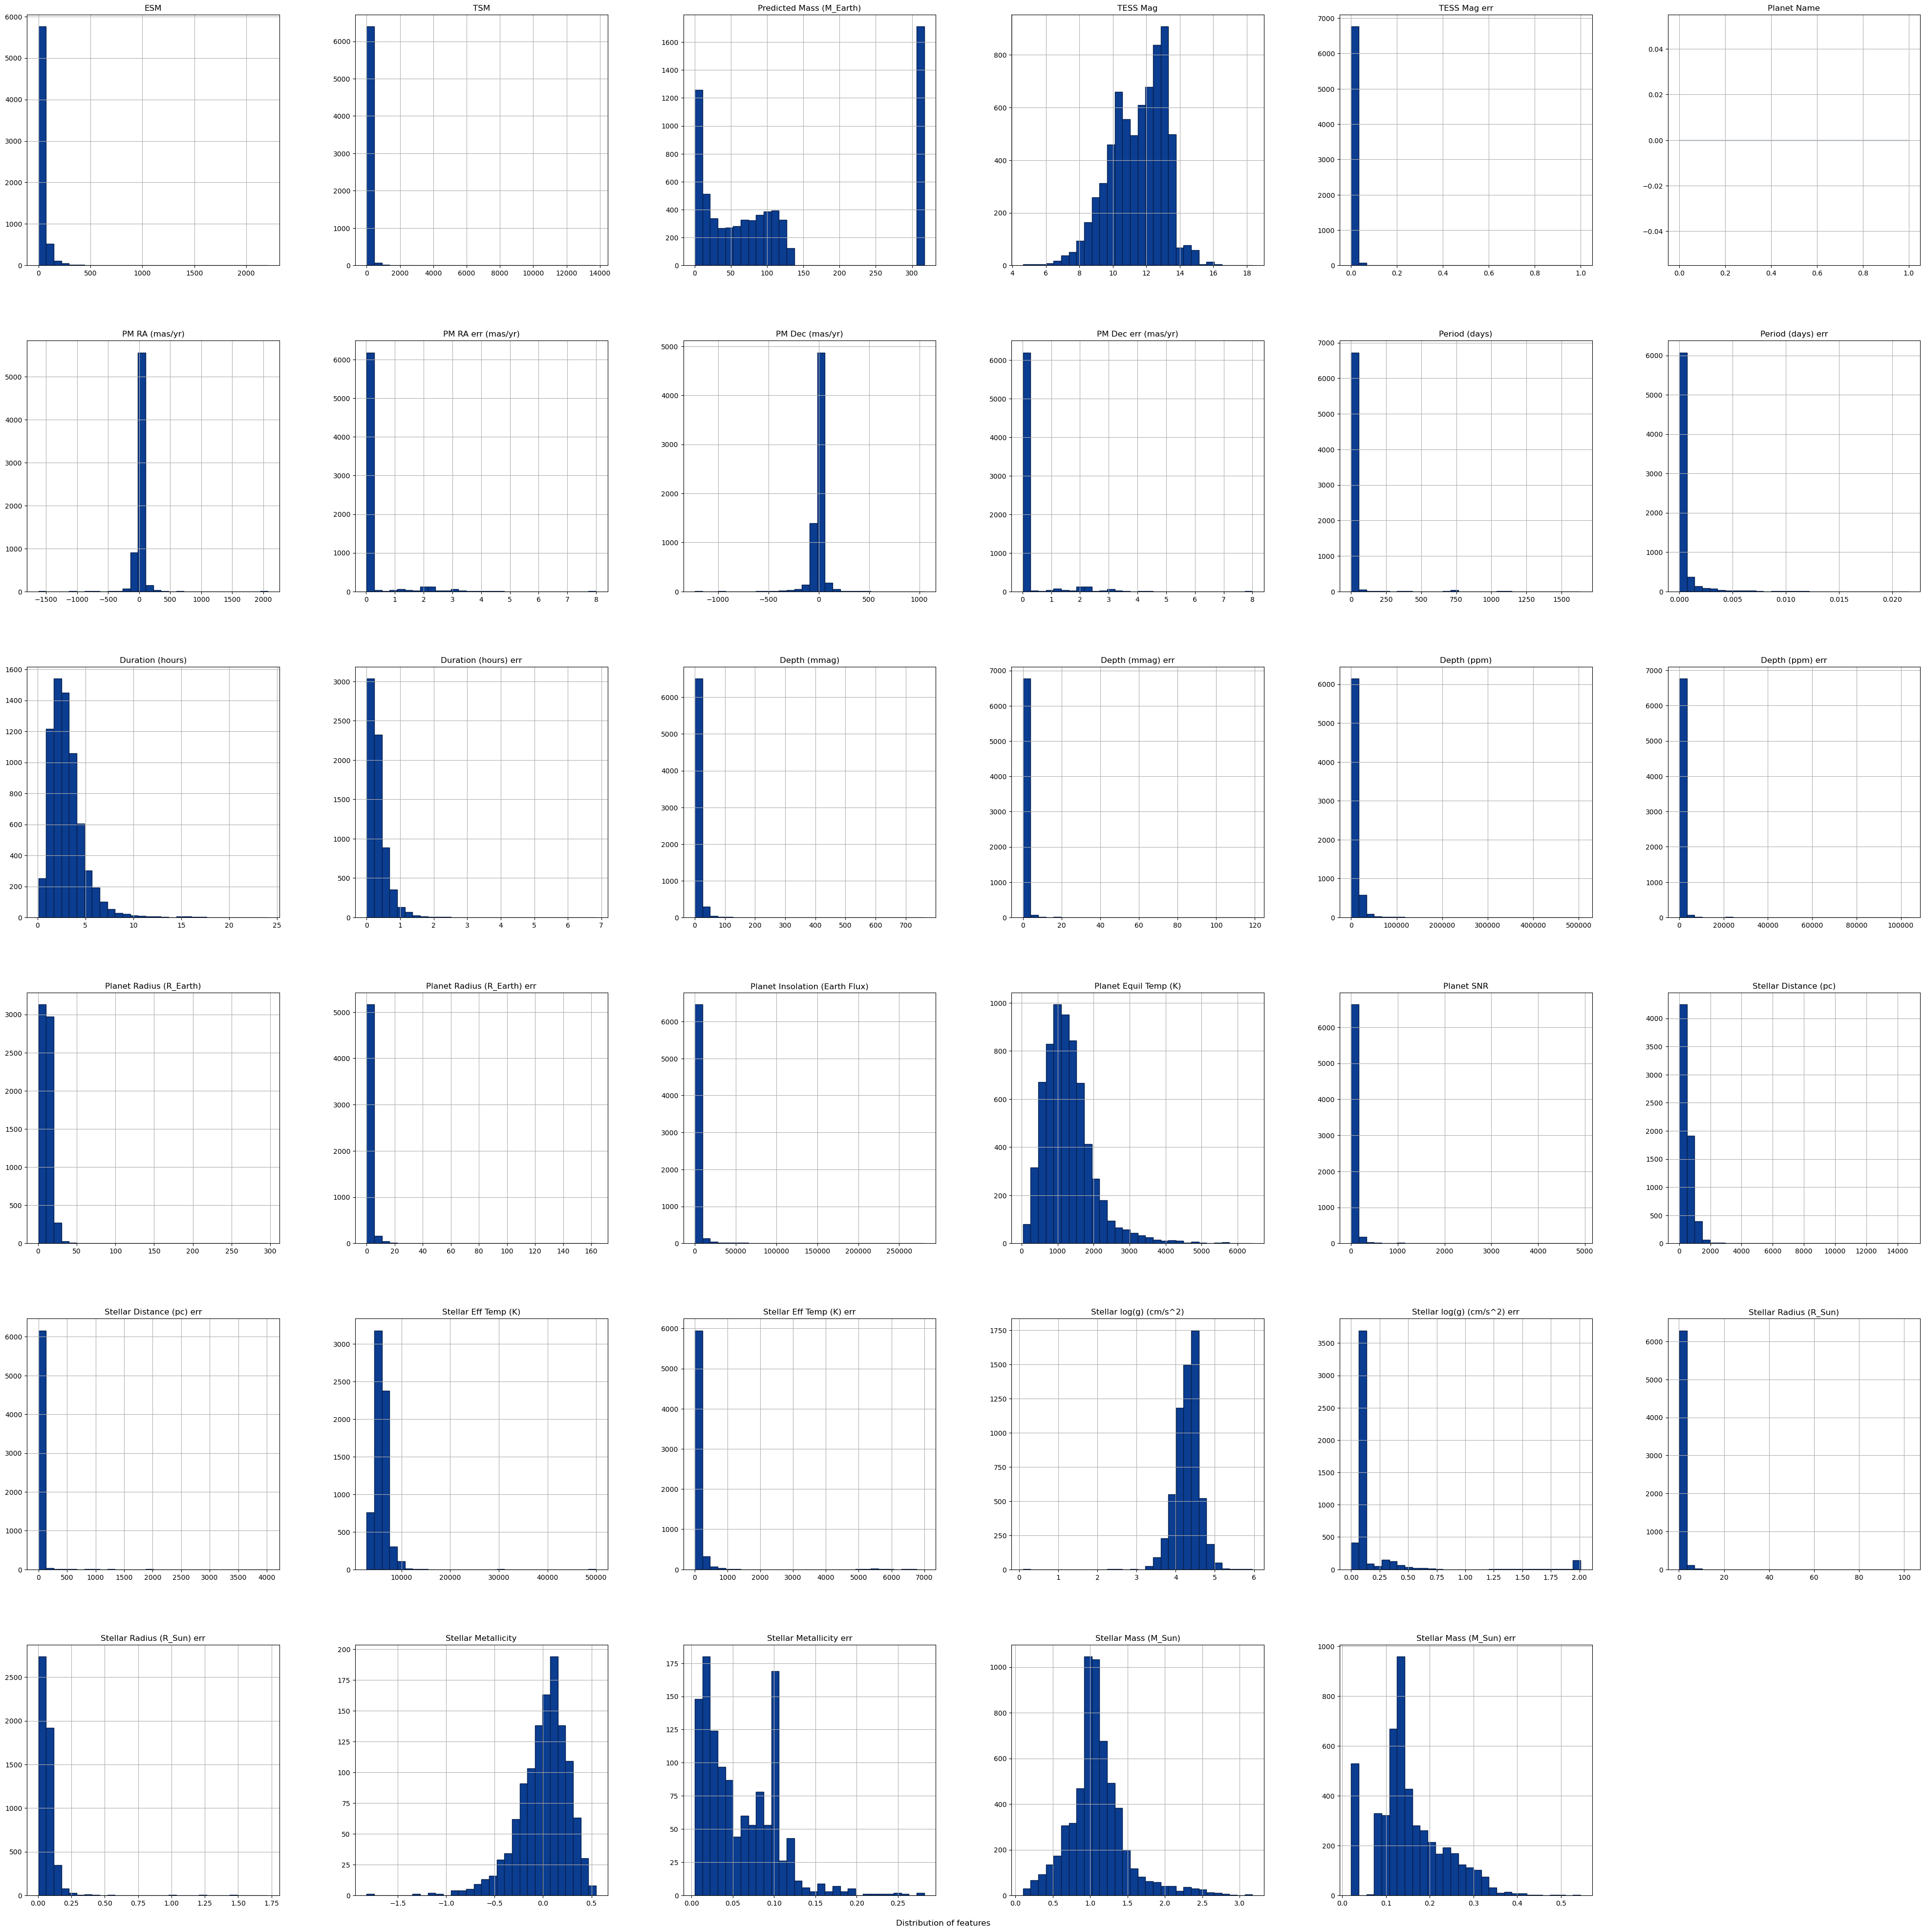

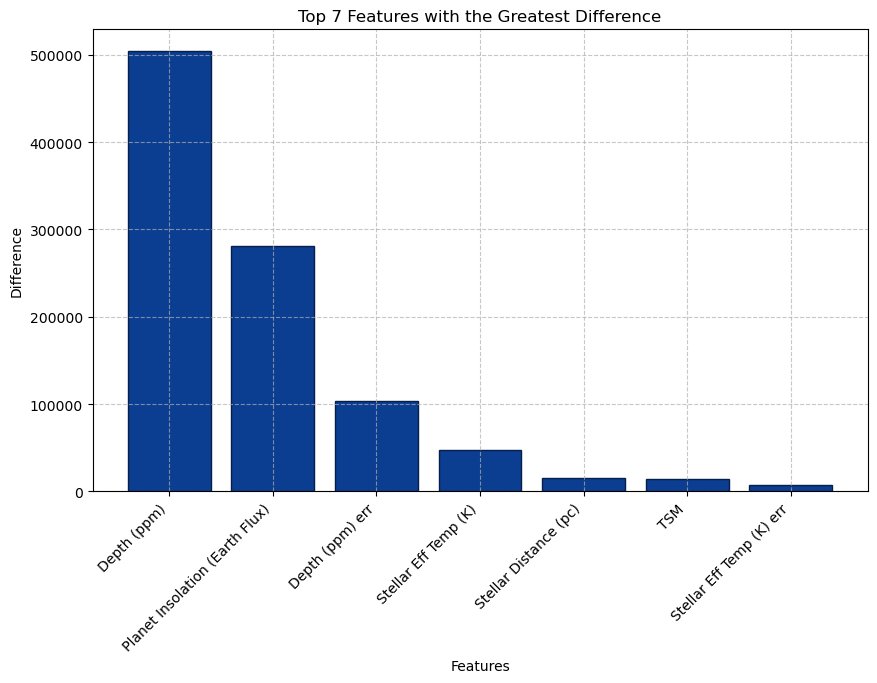

In [10]:
print('Plot Before the scaling')
plot_hist_feature_distributions(X_train=X_train)
plot_top_7_difference(X_train=X_train)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)

/home/a.divicino/miniconda3/envs/exonet/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/a.divicino/miniconda3/envs/exonet/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


# K-Nearest Neighbors

The NaN problem must be managed carefully, there are several solutions that can be used, one of these is the KNN methodology which calculates a distance (e.g. Euclidean or Manhattan) between the observations and calculates the new value to be inserted with some methodologies (e.g. IDWM or IRWM) but considering the nearest K, where K is defined a priori, generally for K the square root of N is considered where N is the number of observations, or an approximation is used.

In this case, for efficiency reasons, the sklearn KNNImputer module was used which is optimized.

Dalla seguente operazione osserviamo che continuano a persistere in NaN in X_train

In [12]:
_ = print_count_nan(data=X_train, name='X_train')

Number of not a numbers values in X_train: 30978 out of 240765: 12.87%


In [13]:
# Calculate columns that contain only nan and the number of nan for each columns
nan_columns = compute_all_columns_nan(data=X_train)
number_of_nan_columns = {col: X_train[col].isna().sum() for col in X_train}
number_of_nan_columns = dict(sorted(number_of_nan_columns.items(), key=lambda x: x[1], reverse=True))
print_nan_numbers_for_features(data=X_train, number_of_nan_columns=number_of_nan_columns)

Columns containing only not a number in X_train: ['Planet Name']
Number of Observations: 6879
NaN for each feature
  1: Planet Name-------------------> 6879
  2: Stellar Metallicity-----------> 5661
  3: Stellar Metallicity err-------> 5661
  4: Stellar log(g) (cm/s^2) err---> 2001
  5: Stellar Mass (M_Sun) err------> 1874
  6: Stellar Radius (R_Sun) err----> 1717
  7: Planet Radius (R_Earth) err---> 1456
  8: Stellar Mass (M_Sun)----------> 915
  9: Stellar log(g) (cm/s^2)-------> 789
 10: Stellar Distance (pc) err-----> 637
 11: Planet Radius (R_Earth)-------> 467
 12: Stellar Radius (R_Sun)--------> 467
 13: Stellar Eff Temp (K) err------> 421
 14: ESM---------------------------> 383
 15: TSM---------------------------> 383
 16: Planet Equil Temp (K)---------> 279
 17: Stellar Distance (pc)---------> 202
 18: Planet Insolation (Earth Flux)> 155
 19: Stellar Eff Temp (K)----------> 130
 20: PM RA (mas/yr)----------------> 119
 21: PM RA err (mas/yr)------------> 119
 22: PM Dec (mas/

In [14]:
TCOL = 5000
nan_columns = threshold_delete_nan(number_of_nan_columns=number_of_nan_columns,
                                        nan_columns_name=nan_columns, threshold=TCOL)
X_train = X_train.drop(columns=nan_columns)
_ = print_count_nan(data=X_train, name='X_train')
print('Shape:', X_train.shape)

Number of not a numbers values in X_train: 12777 out of 220128: 5.80%
Shape: (6879, 32)


In [15]:
# Compute the number of not a number for each rows
number_of_nan_rows = X_train.isna().sum(axis=1)
TROW = 10
id_rows = rows_id_nan(number_of_nan_rows=number_of_nan_rows,
                      X_train=X_train, threshold=TROW)

Total rows >= of T=10: 325 out of a total of 6879 By eliminating them you obtain 6554 observations


In [16]:
# Drop rows >= T
X_train = X_train.drop(id_rows).reset_index(drop=True)
y_train = y_train.drop(id_rows).reset_index(drop=True)
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')

Shape of X_train: (6554, 32)
Number of not a numbers values in X_train: 8600 out of 209728: 4.10%


In [17]:
INDEX_OF_K = 10
# Using KNNImputer
X_train = k_nearest_neighbors_imputer(X_train, INDEX_OF_K)
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Number of not a numbers values in X_train: 8600 out of 209728: 4.10%
Shape of X_train: (6554, 32)
Number of not a numbers values in X_train: 0 out of 209728: 0.00%
Shape of X_train data:  (6554, 32)
Shape of y_train data:  (6554,)


Plot After the scaling and KNNImputer


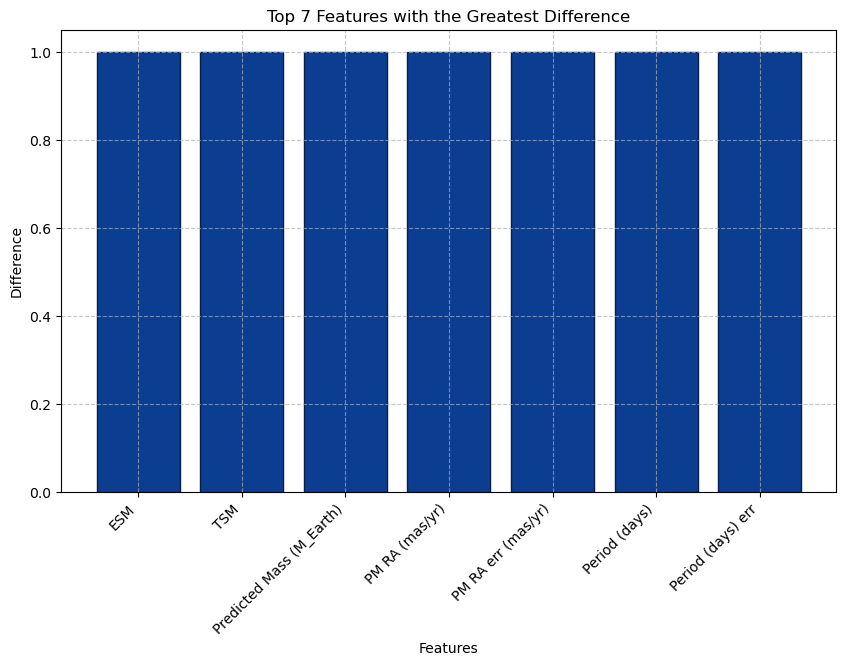

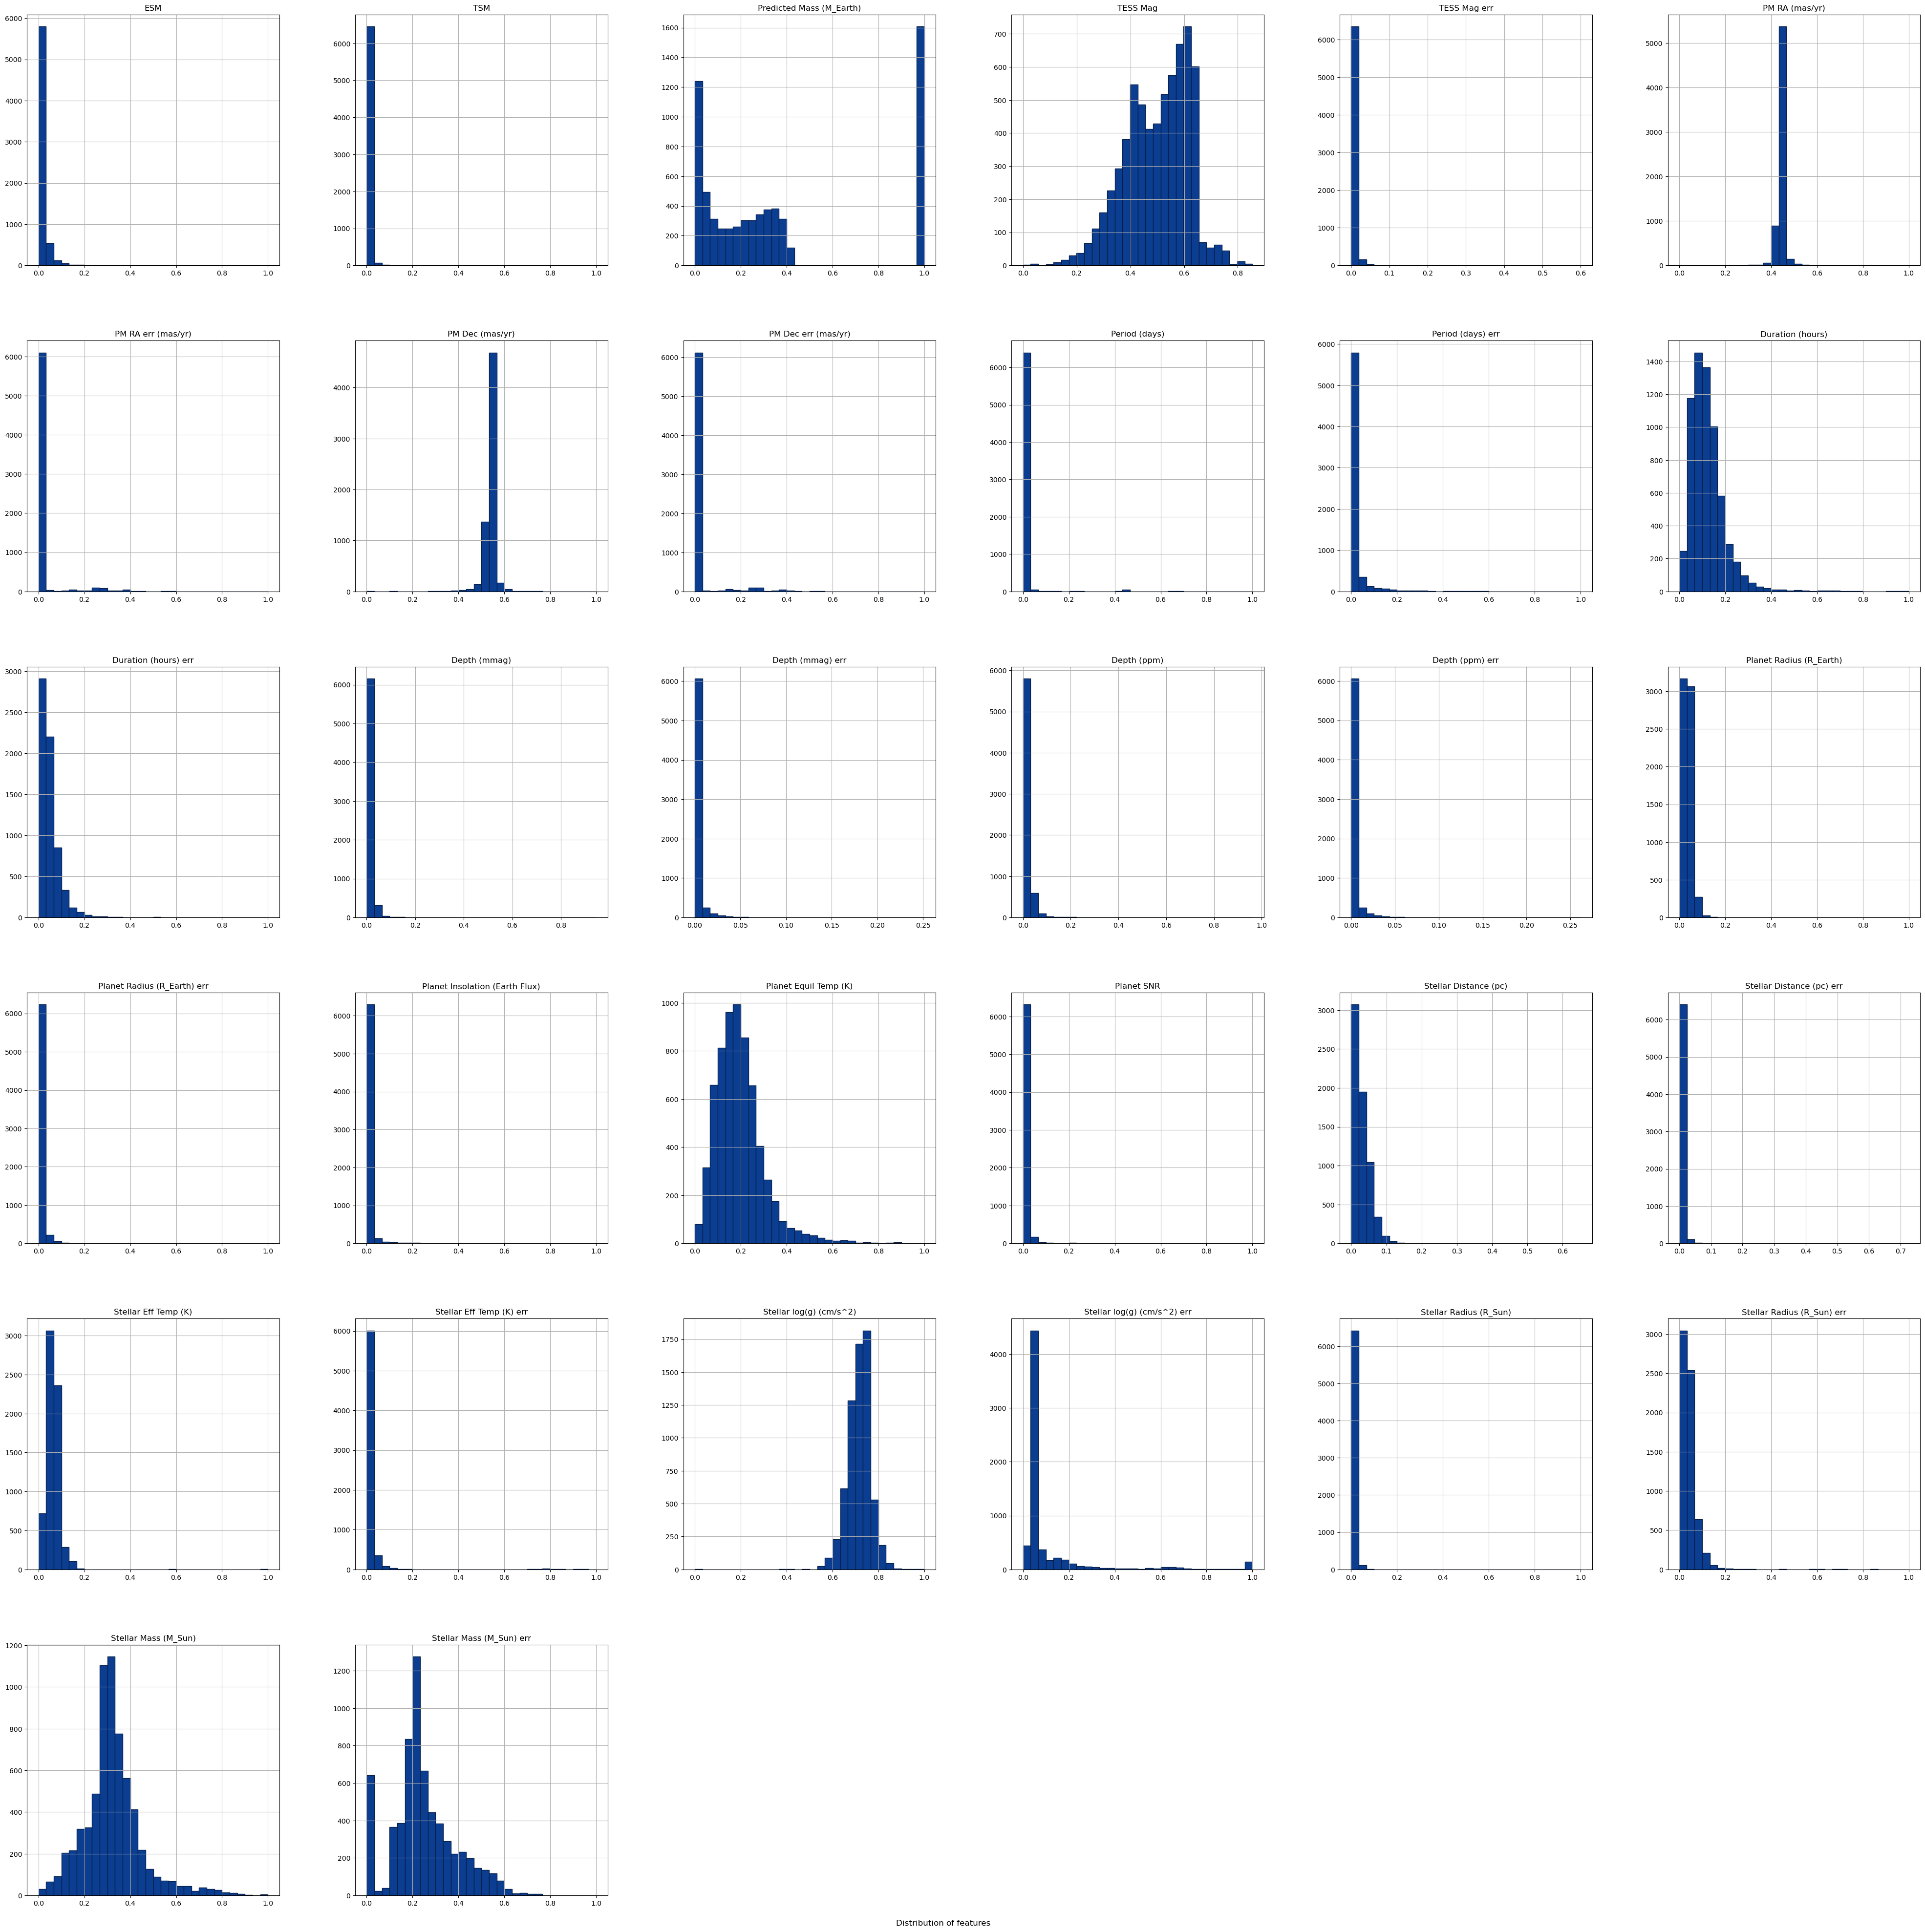

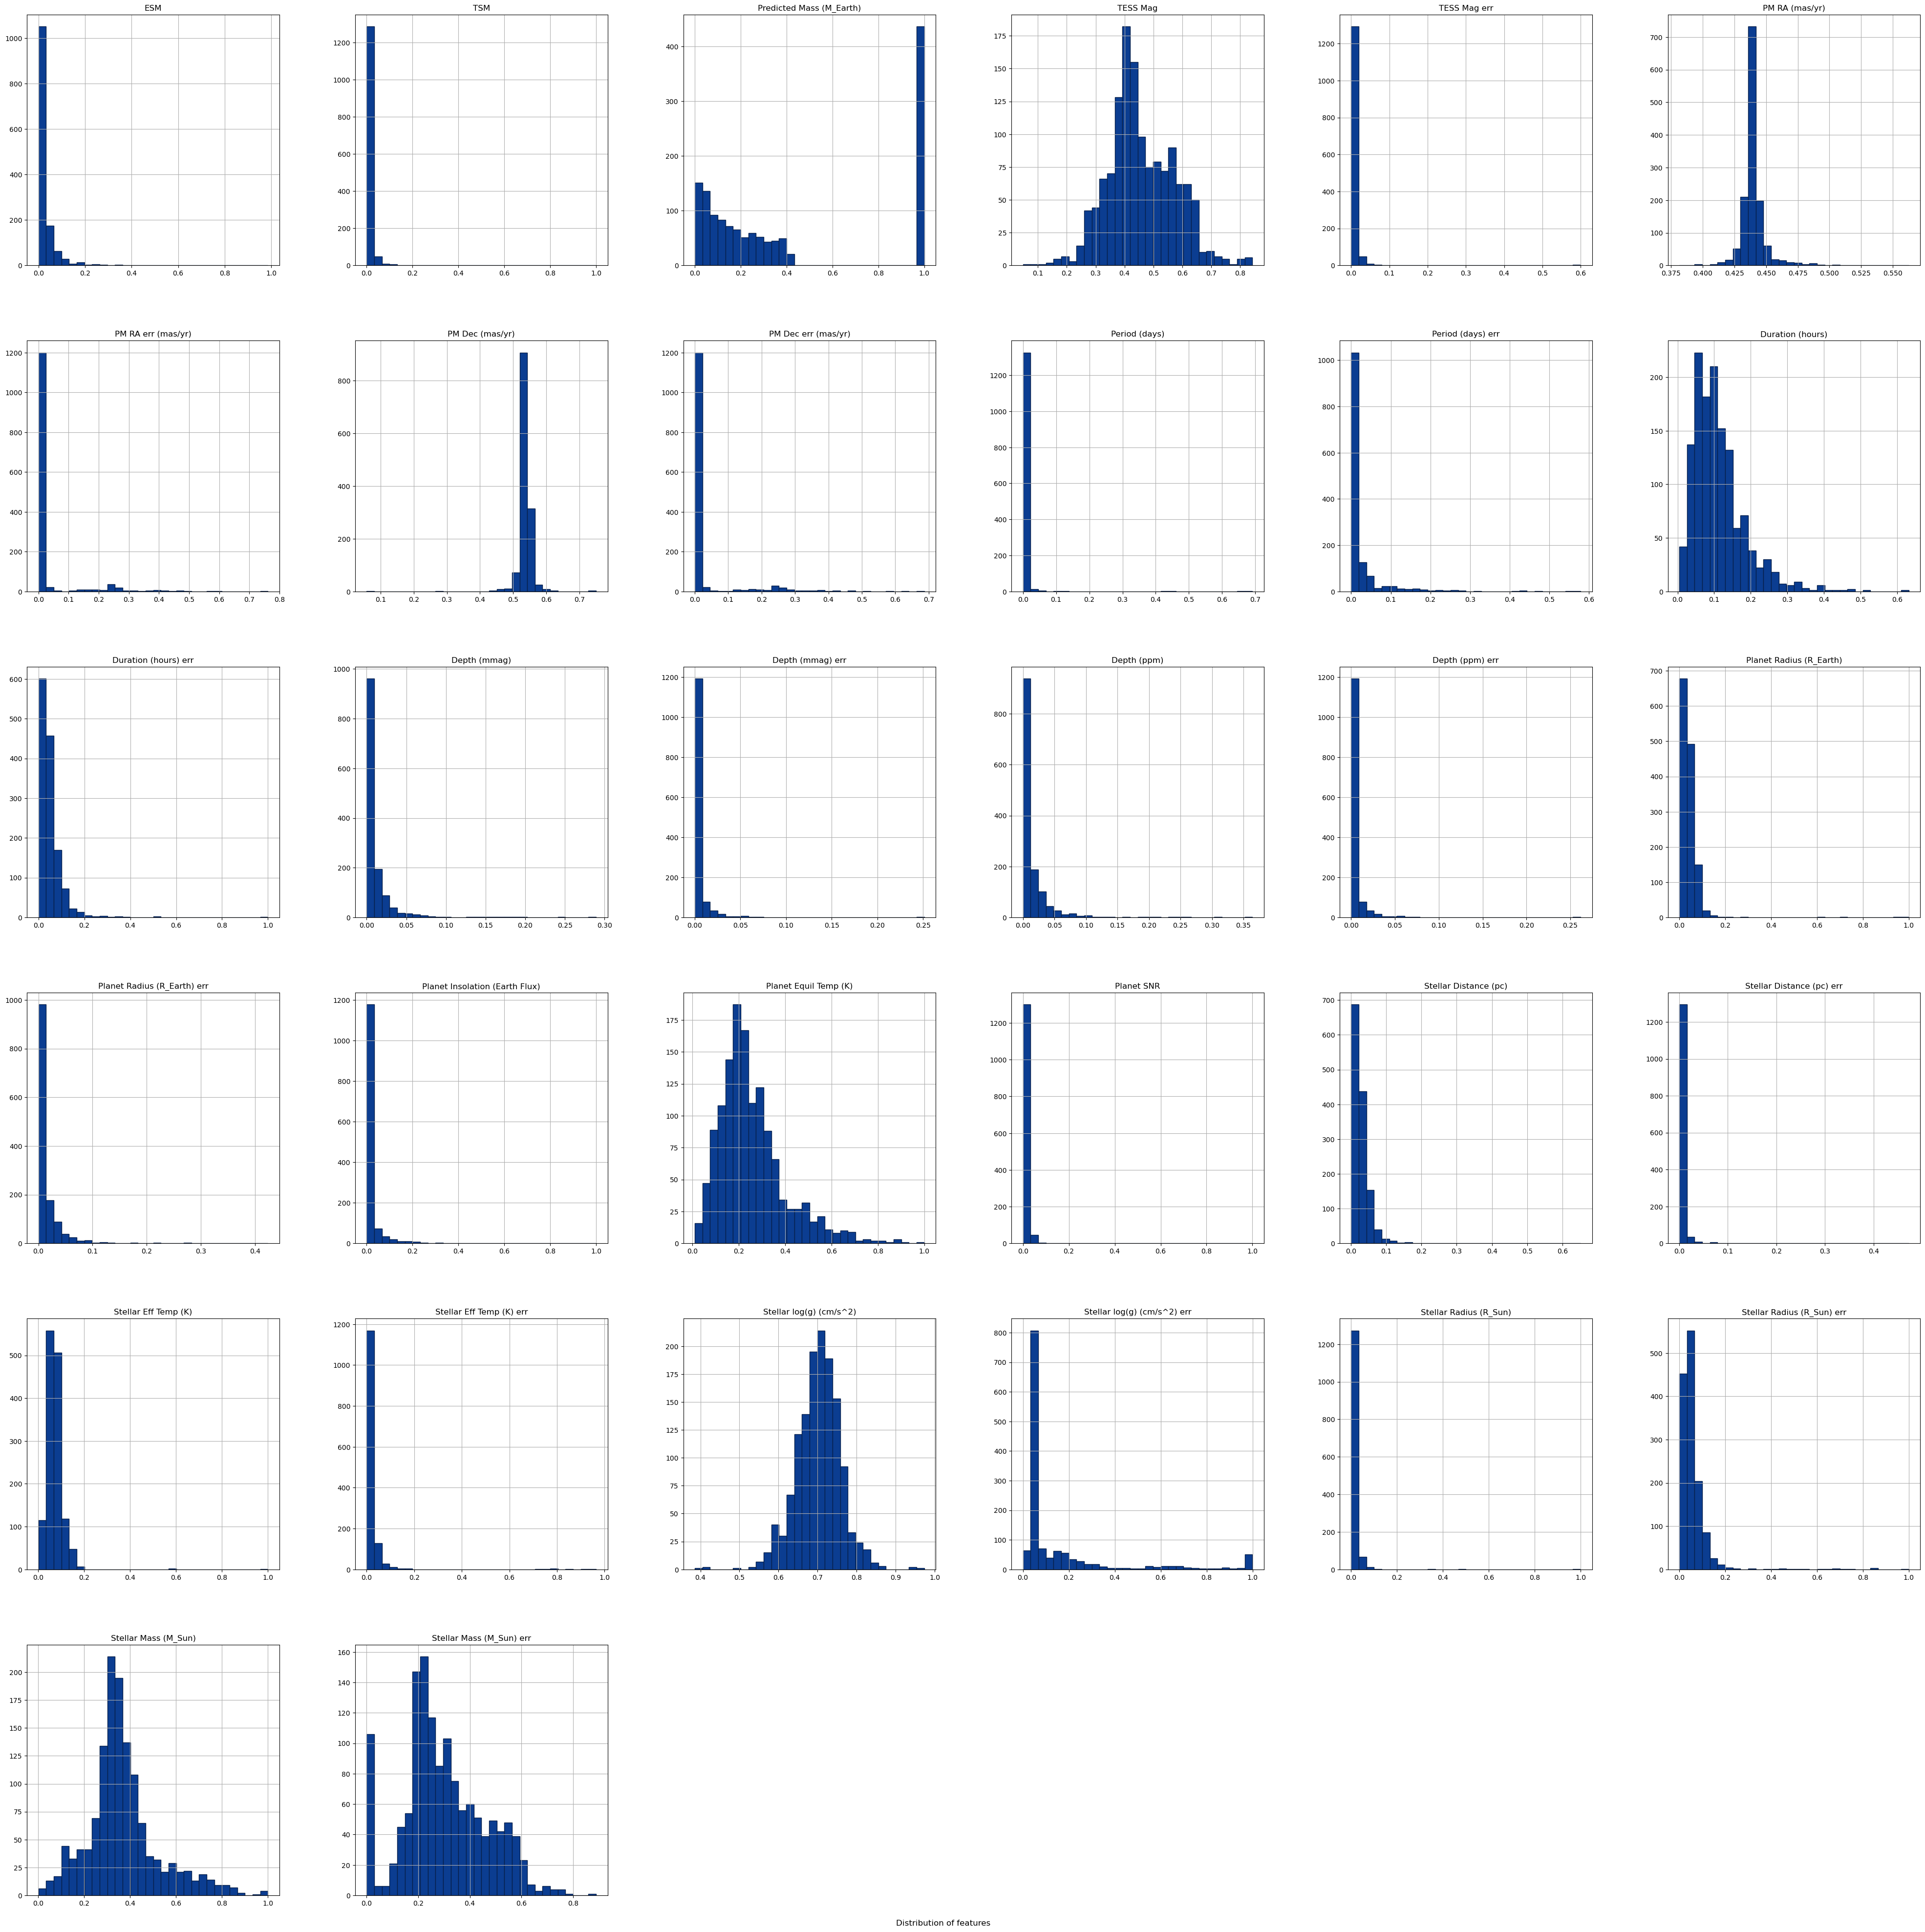

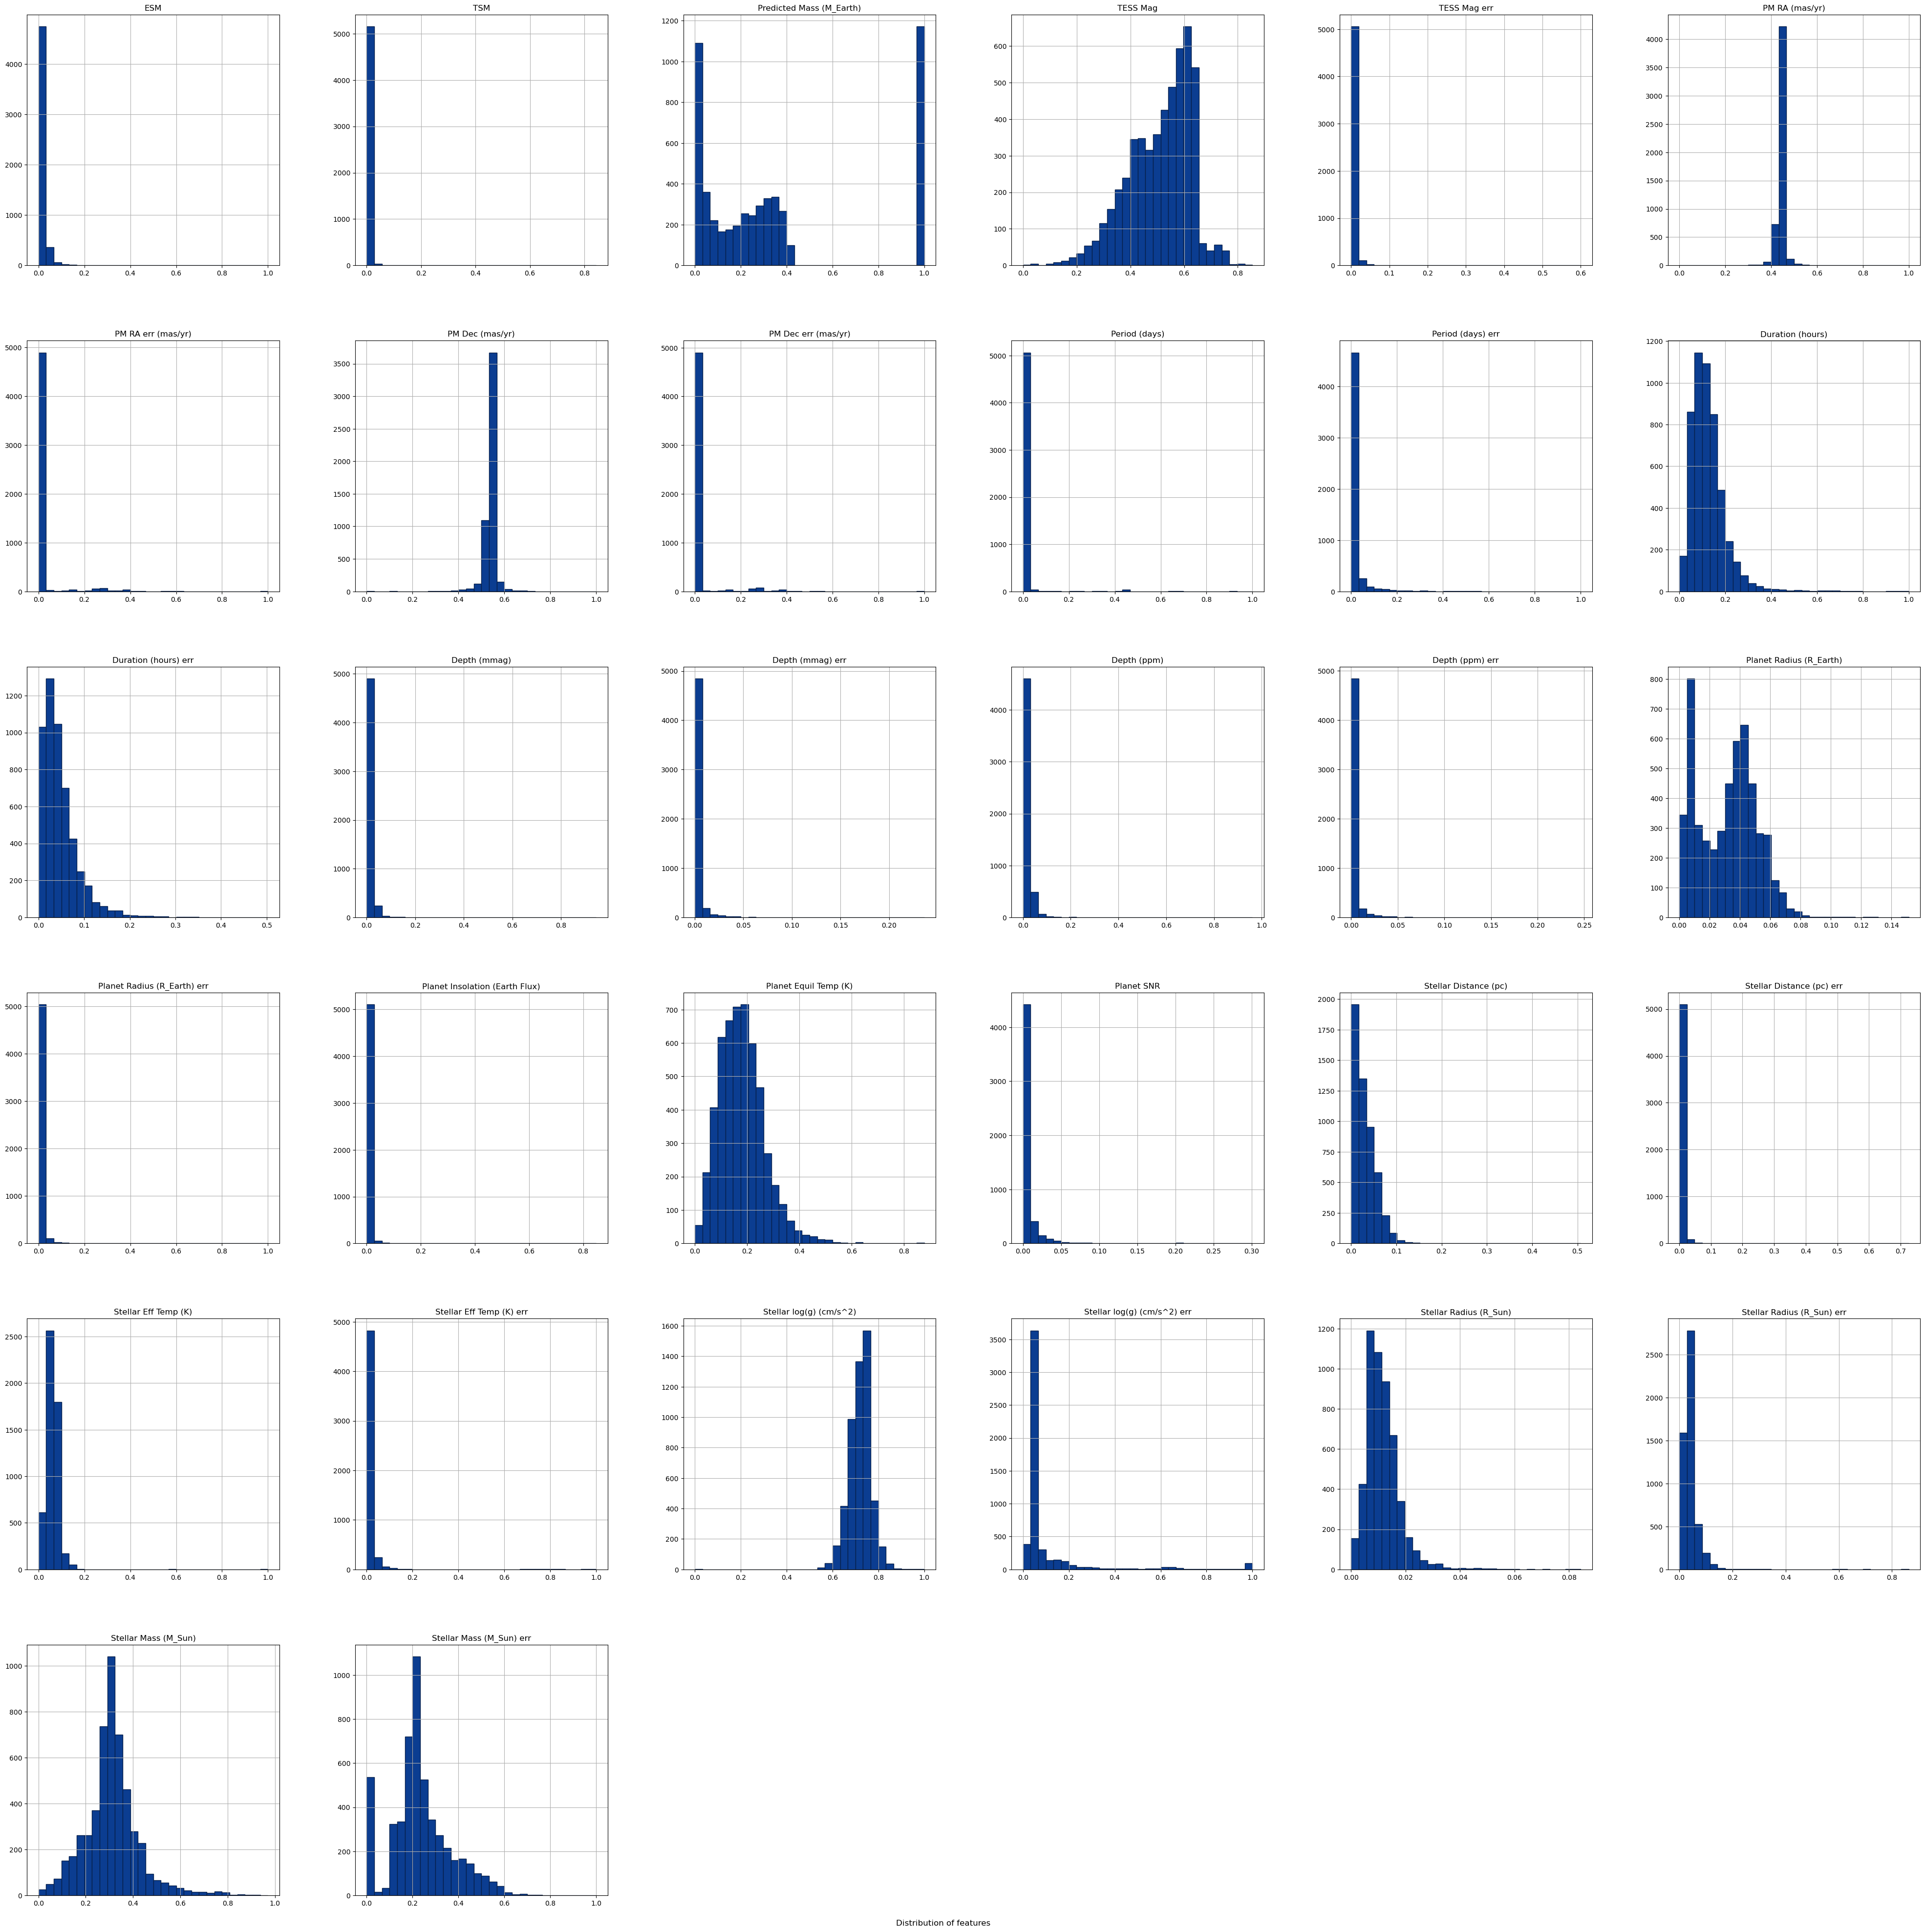

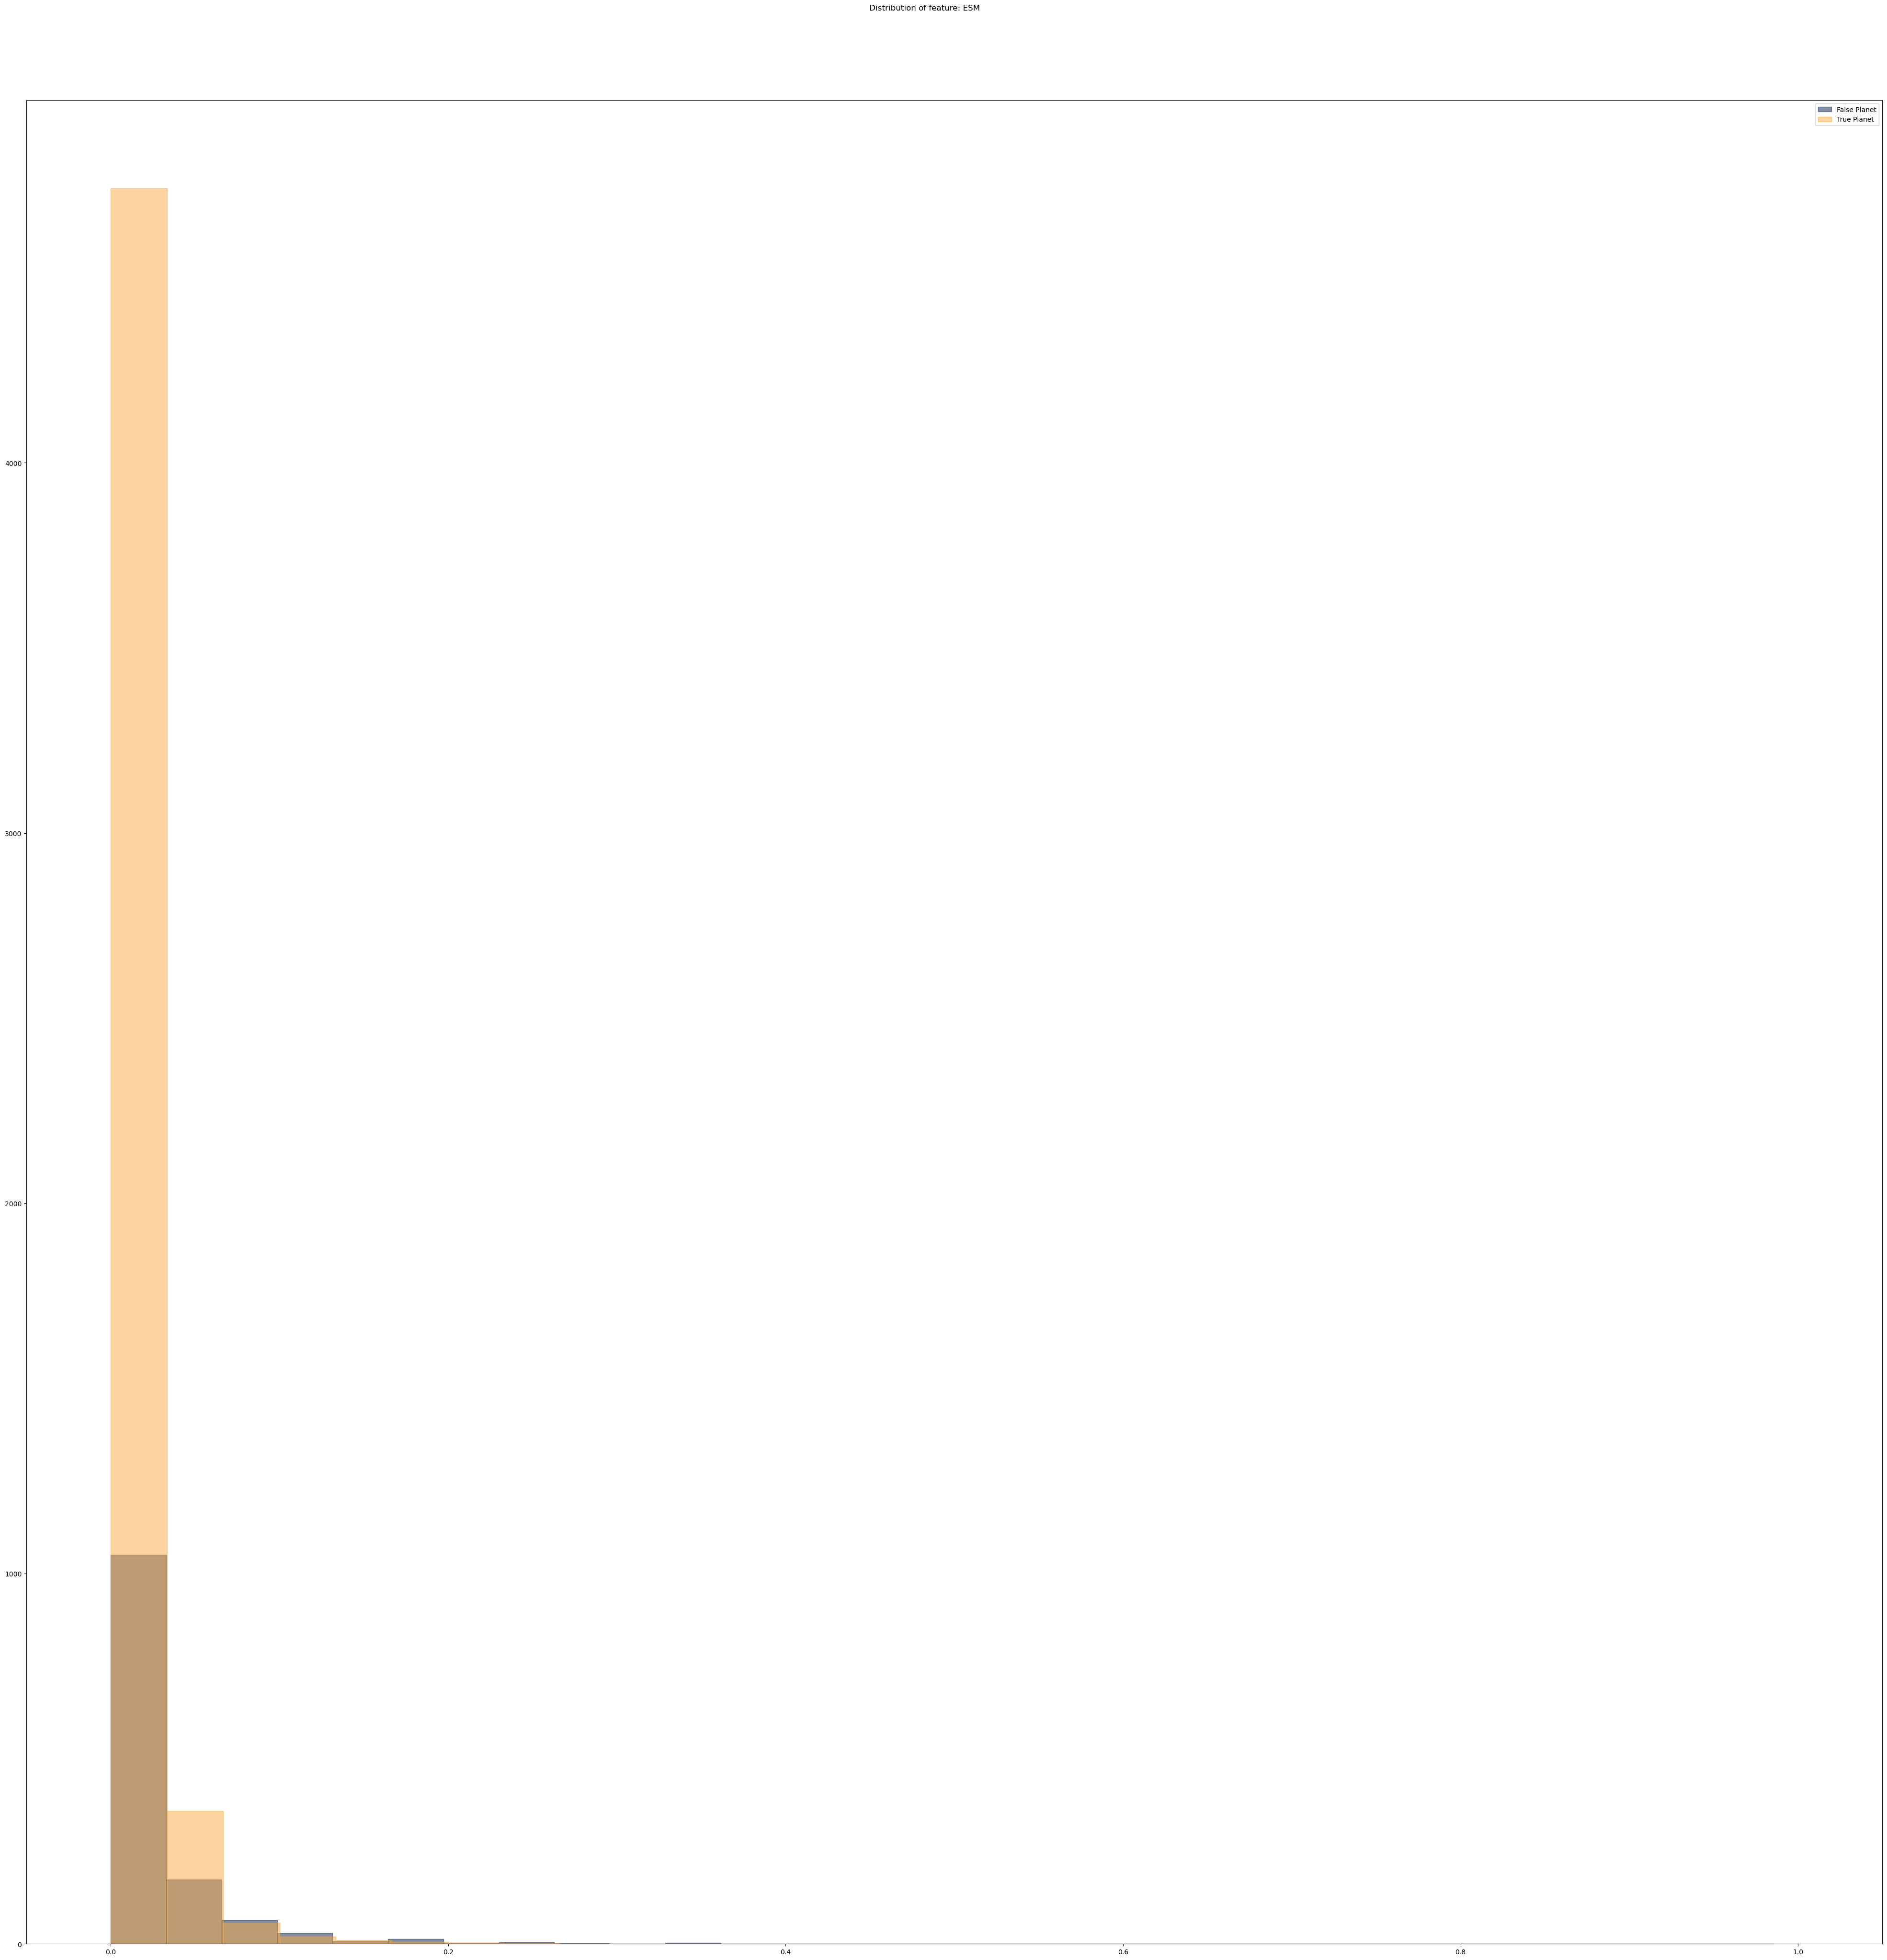

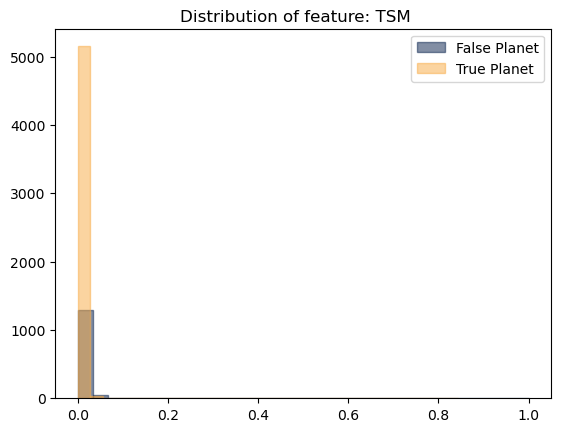

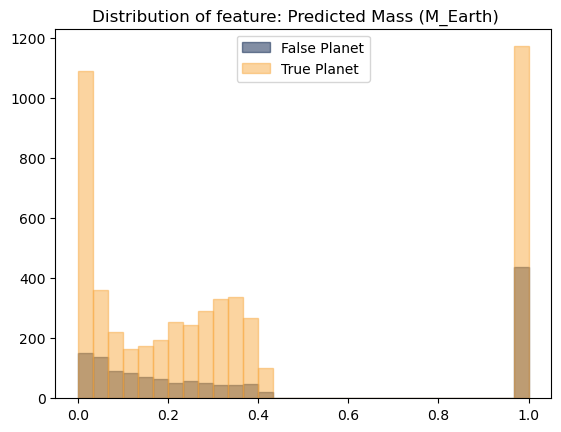

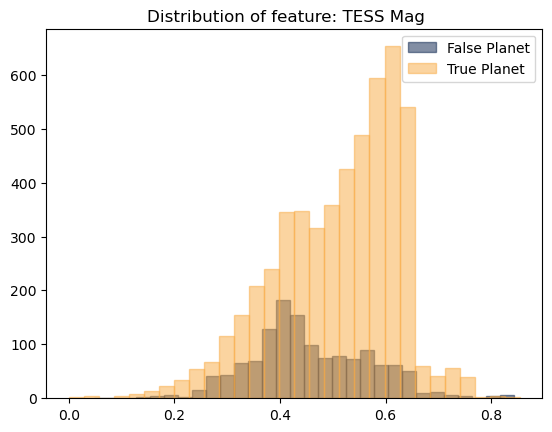

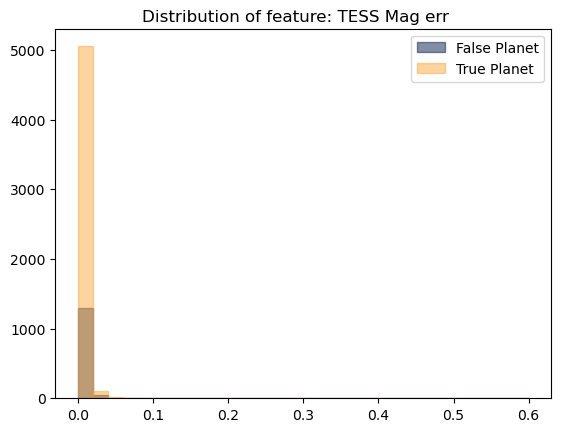

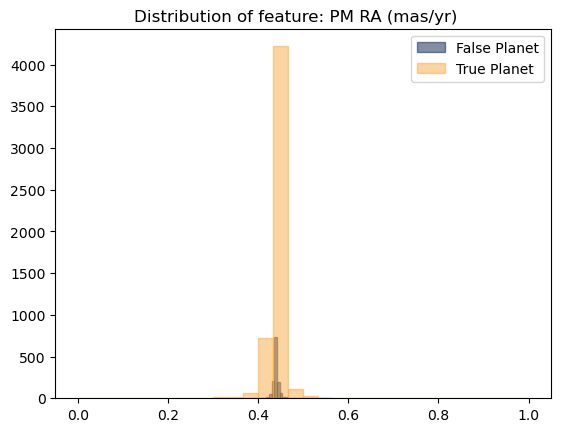

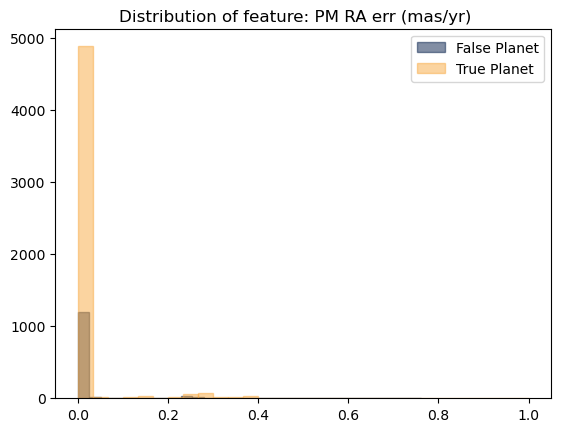

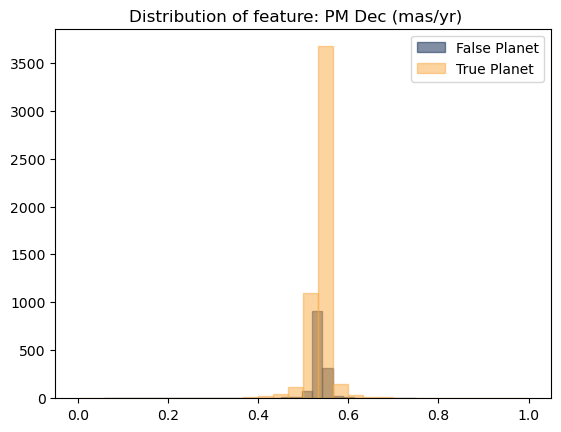

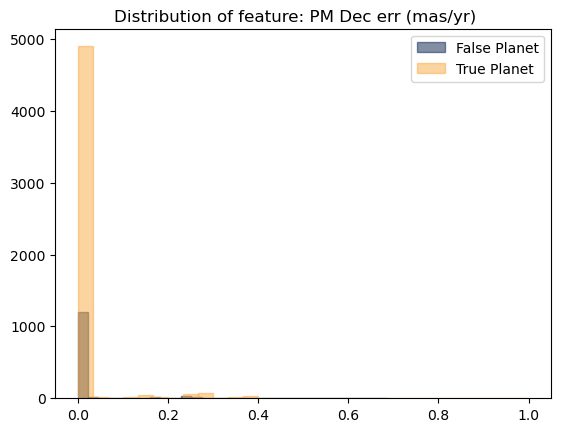

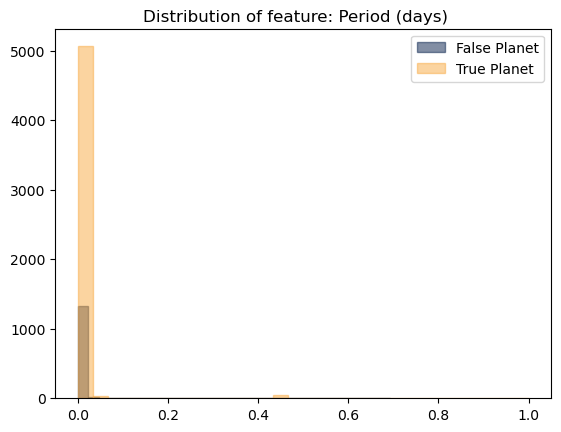

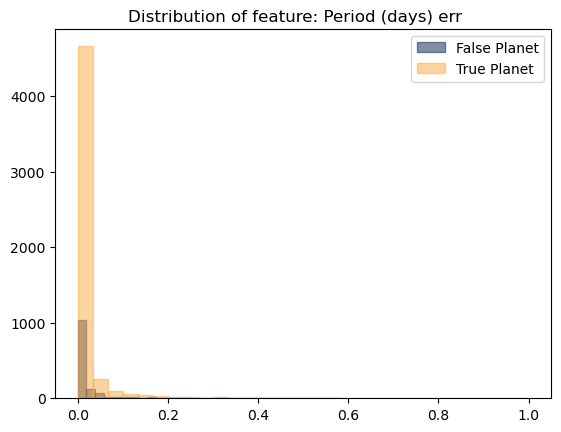

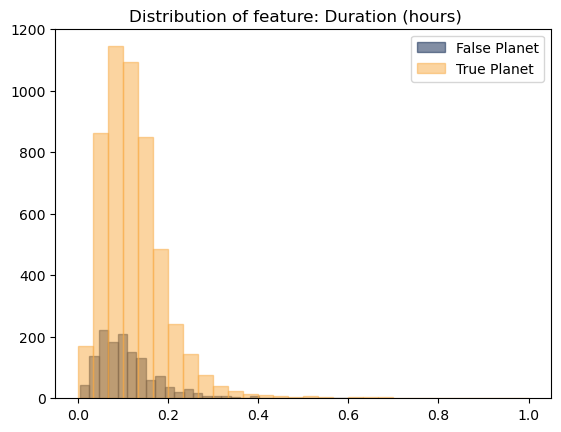

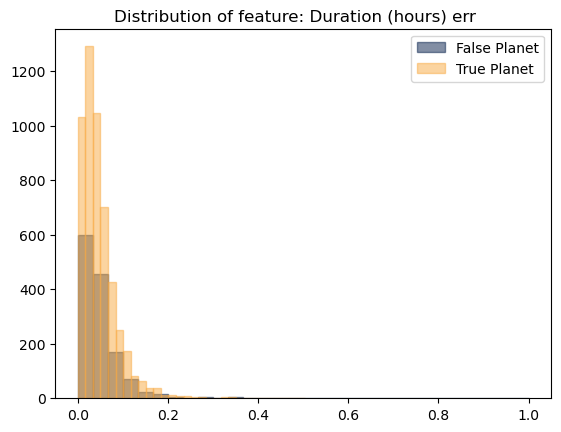

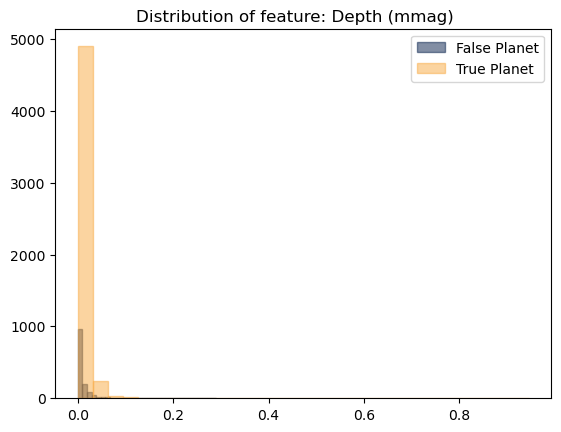

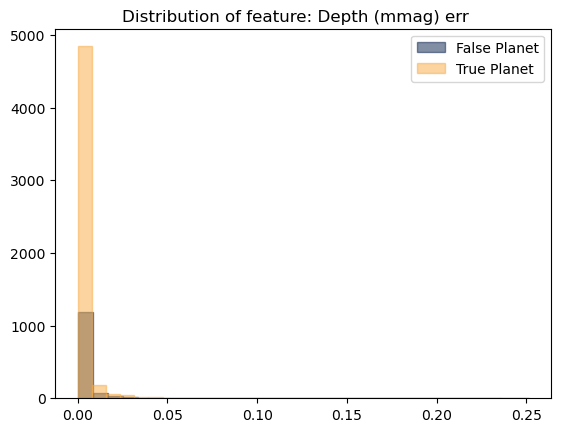

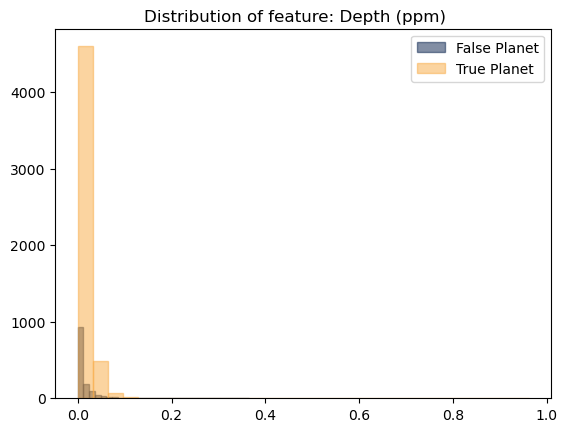

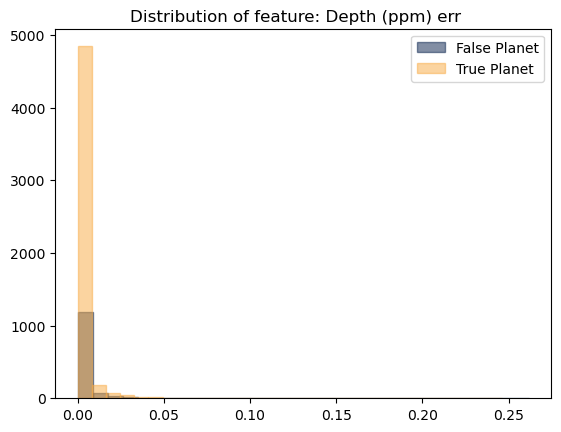

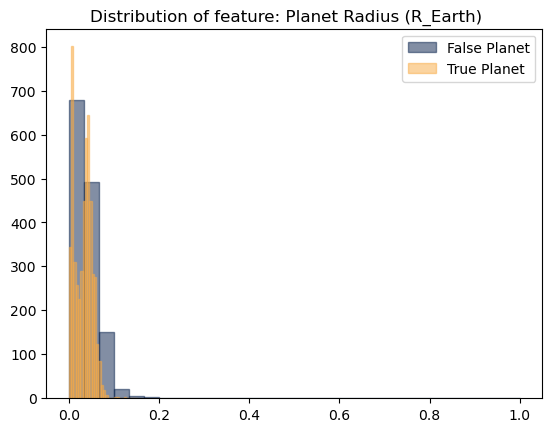

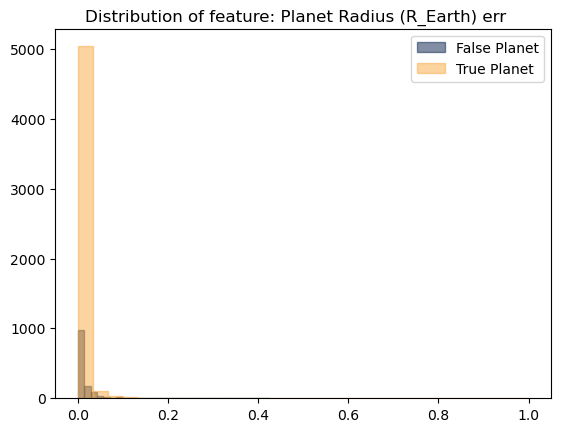

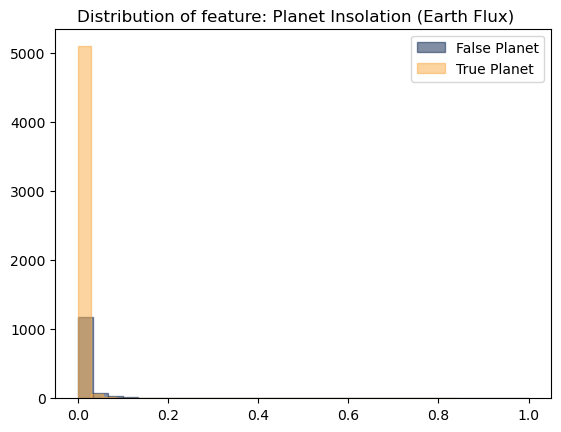

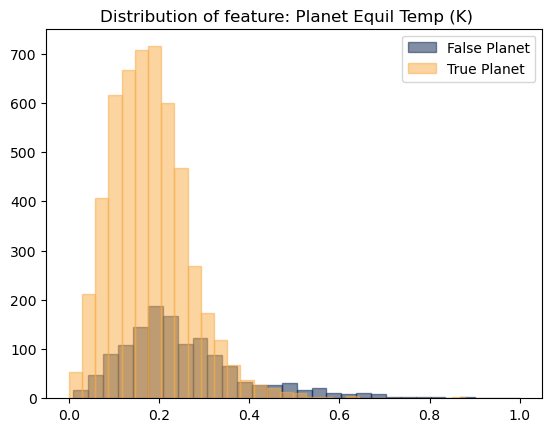

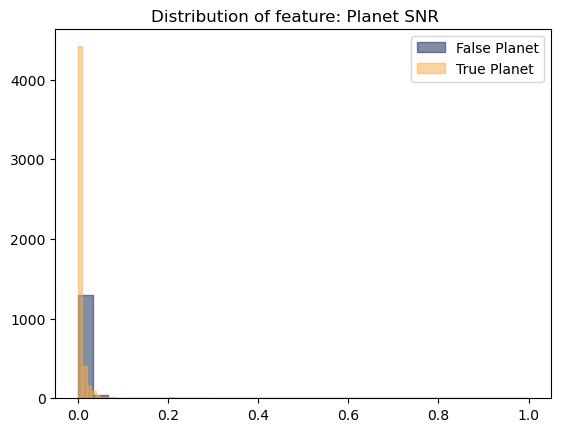

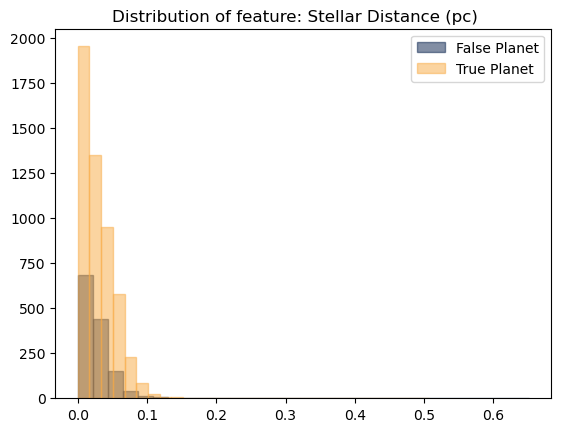

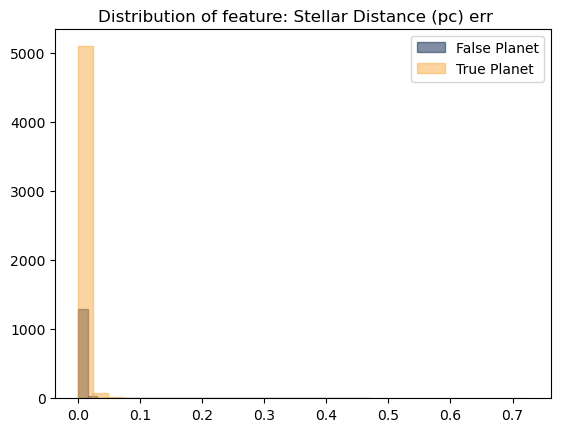

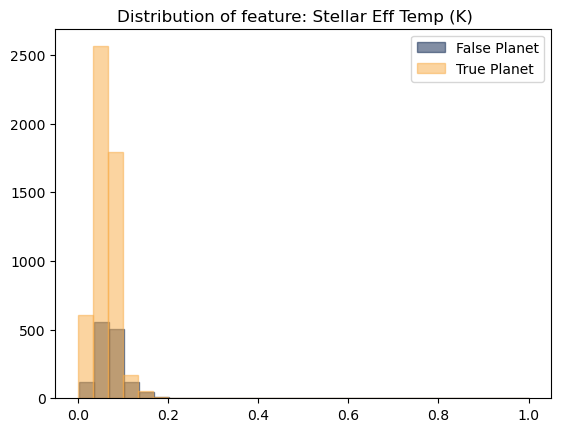

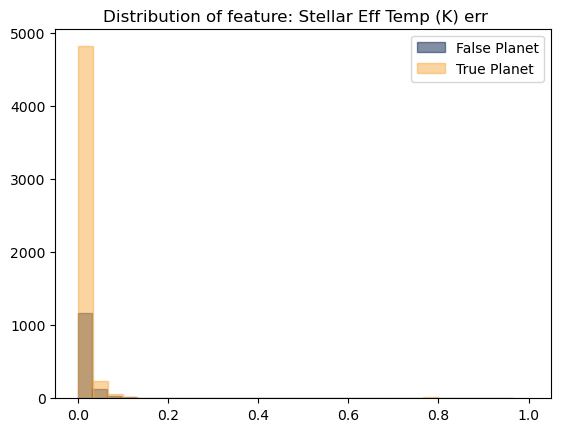

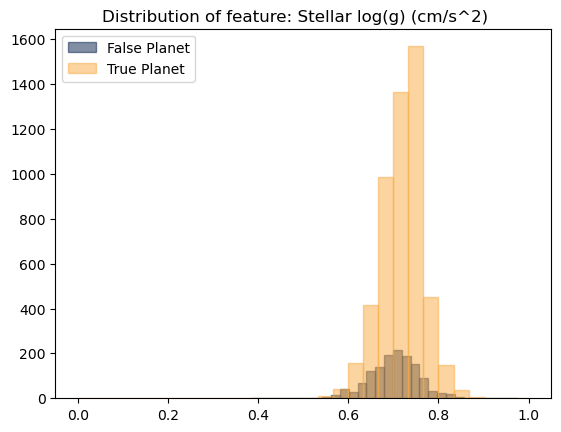

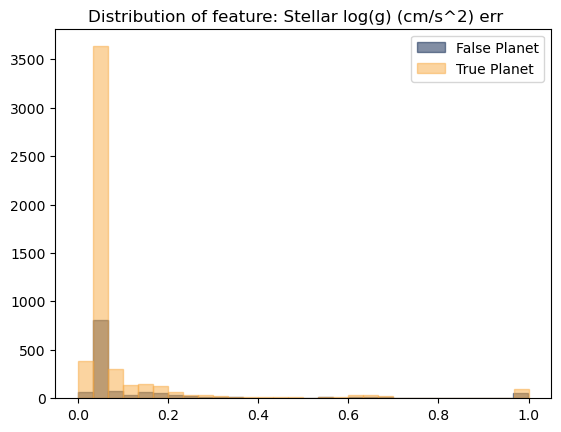

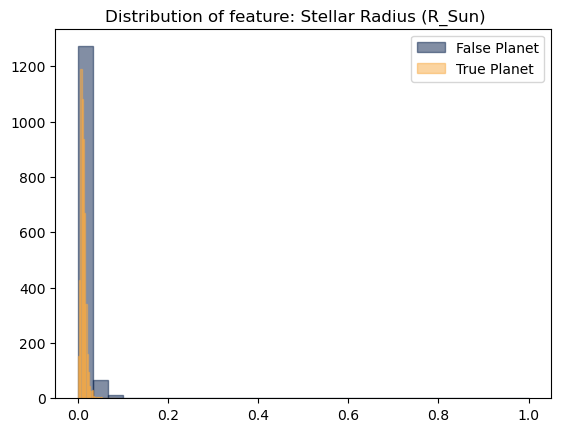

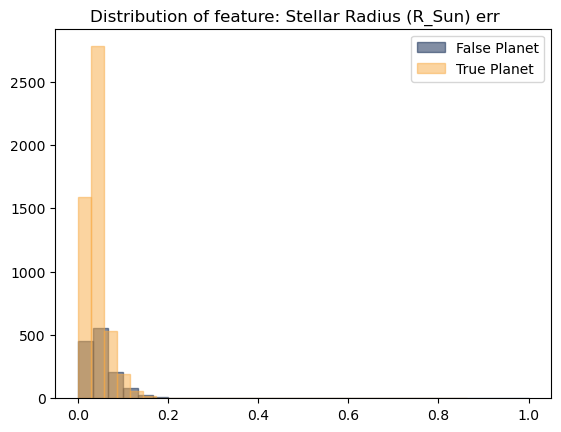

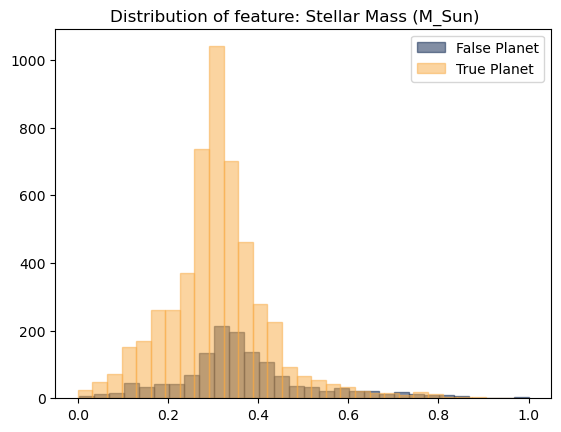

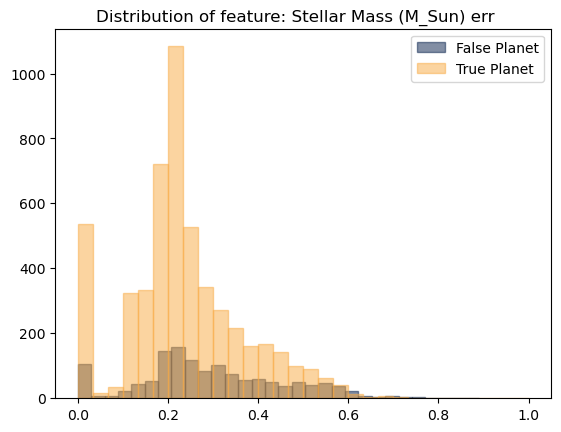

In [18]:
print('Plot After the scaling and KNNImputer')
plot_top_7_difference(X_train=X_train)
plot_hist_feature_distributions(X_train=X_train)
X_train_0, X_train_1 = compute_train_0_1(X_train=X_train, y_train=y_train)
plot_hist_feature_distributions(X_train=X_train_0)
plot_hist_feature_distributions(X_train=X_train_1)
plot_hist_feature_distributions_0_1(X_train_0=X_train_0, X_train_1=X_train_1)

# Features Selection

Feature selection is a technique that associates a score with each feature and, based on a threshold T, thresholding is carried out so as to leave only the most important features. This technique is used to reduce overfitting and computational times.

It is done through the use of a Random Forest which provides us with the importance of the features.

In [19]:
N_JOBS = -1

In [20]:
feature_importances_ = compute_feature_importance(X_train=X_train, y_train=y_train, n_jobs=N_JOBS)
print_feature_importance(X_train=X_train, feature_importances_=feature_importances_)

1: TESS Mag----------------------> 0.050784220367772234
2: Planet Equil Temp (K)---------> 0.048815836755108824
3: Planet Insolation (Earth Flux)> 0.04865002621977428
4: Period (days)-----------------> 0.04715432844681214
5: Planet Radius (R_Earth)-------> 0.04535851804090238
6: Period (days) err-------------> 0.044573183556444844
7: Planet Radius (R_Earth) err---> 0.04152815901992115
8: Duration (hours)--------------> 0.039108847922090496
9: TSM---------------------------> 0.03848227903099315
10:ESM---------------------------> 0.033614744880479455
11:Stellar Radius (R_Sun)--------> 0.029919539226874414
12:Stellar Distance (pc)---------> 0.029918915338656923
13:Stellar Radius (R_Sun) err----> 0.029566566084943038
14:Depth (mmag)------------------> 0.028962400801683816
15:Depth (ppm)-------------------> 0.028700513472273835
16:Duration (hours) err----------> 0.027727938327736214
17:Stellar Distance (pc) err-----> 0.027084934667227906
18:Stellar Eff Temp (K) err------> 0.0270769597392680

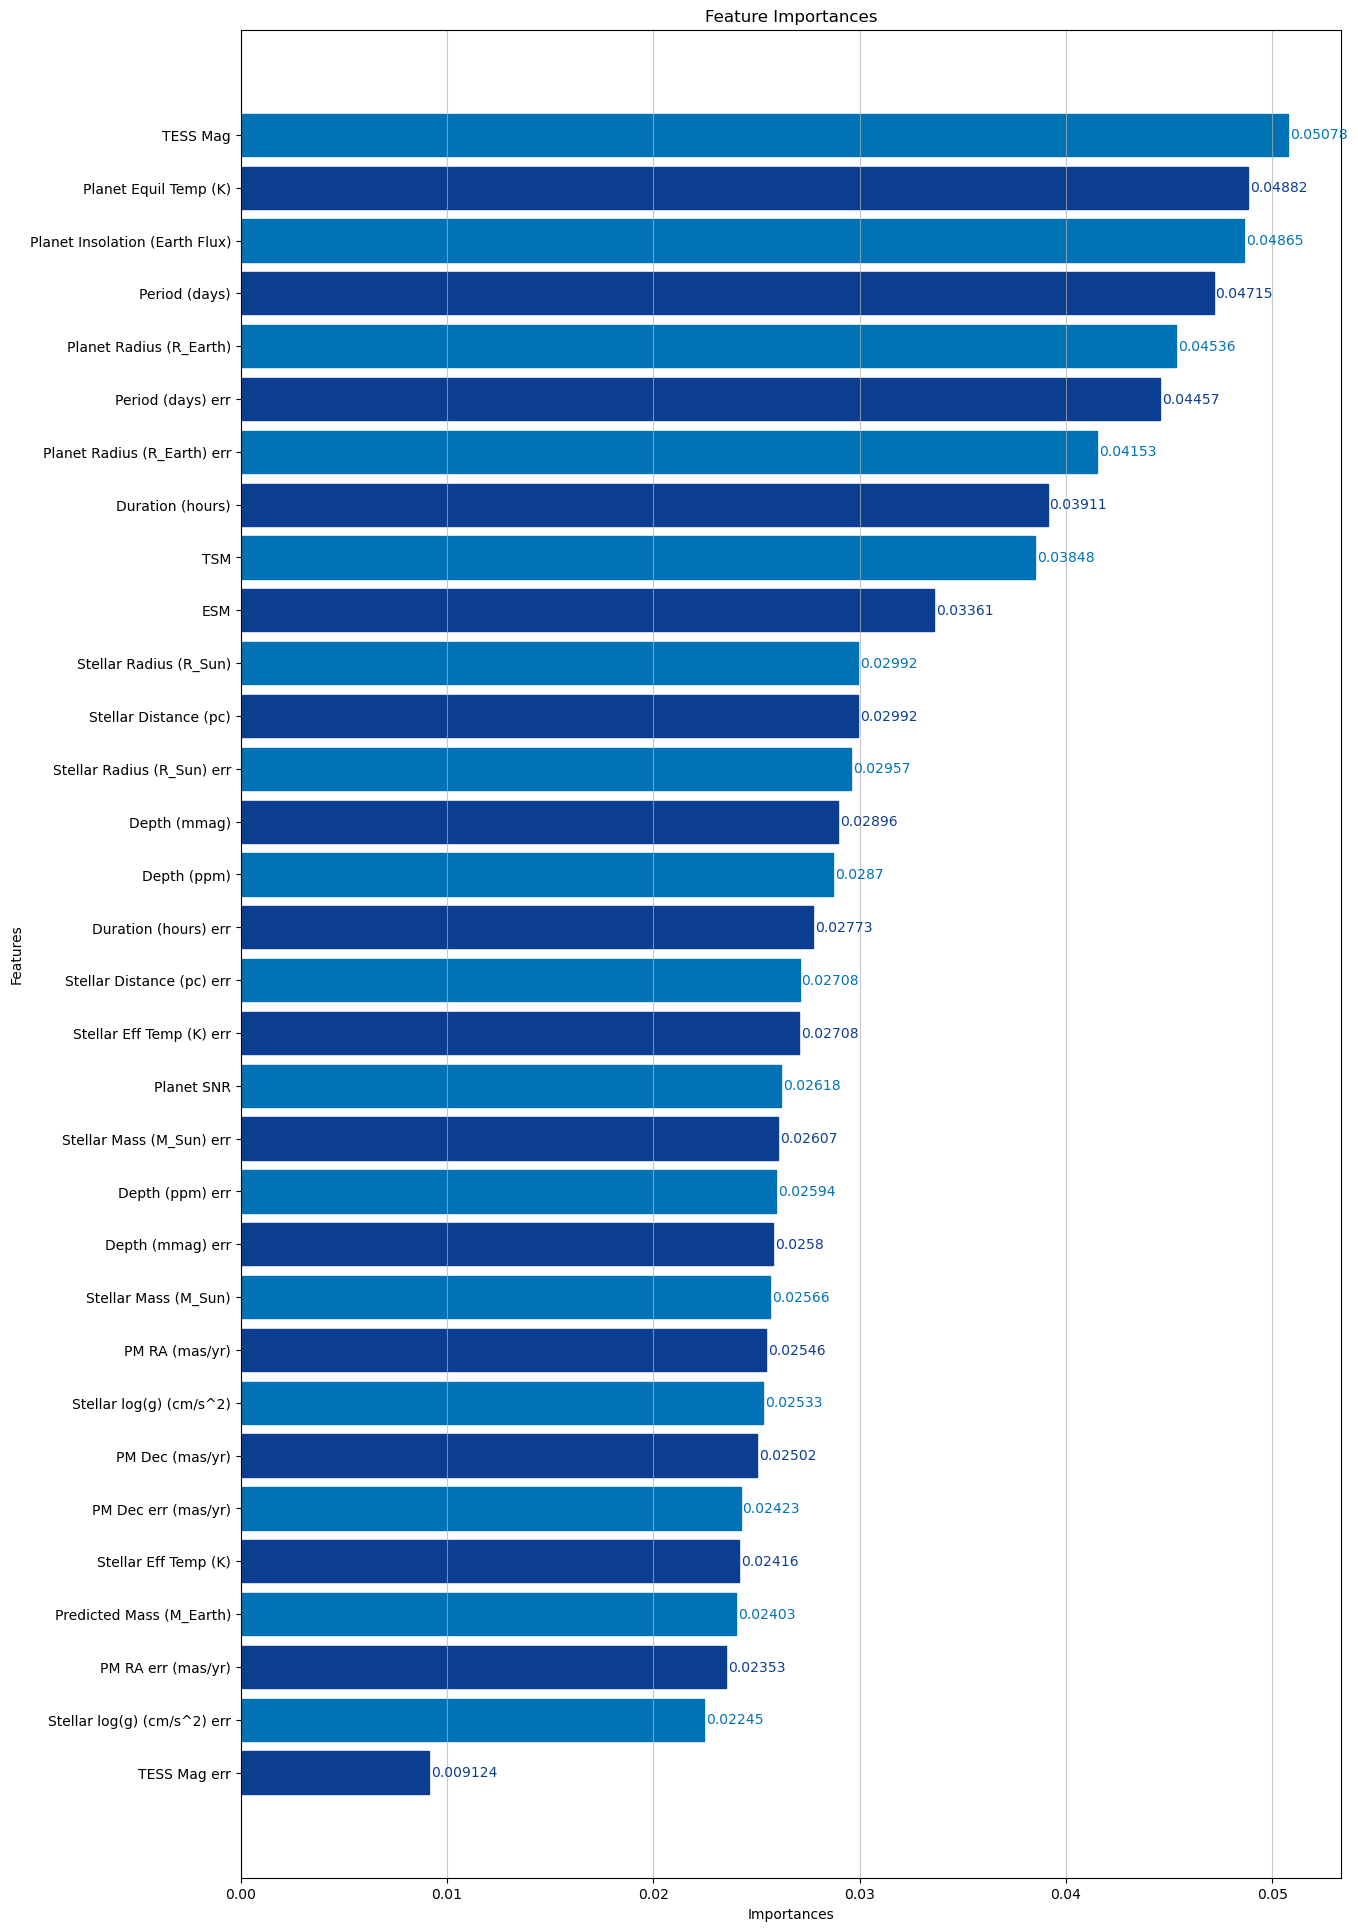

In [21]:
plot_feature_importances(X_train=X_train, feature_importances=feature_importances_)

In [22]:
PERCENTAGE = None # Drop features with importance = 0 + min
X_train, columns_to_drop = feature_selection_rfc(X_train=X_train, feature_importances=feature_importances_,
                                                 percentage=PERCENTAGE)
print('Columns to drop:', columns_to_drop)
print('Shape of X_train data: ', X_train.shape)

Threshold computed:  0
Columns to drop: Index([], dtype='object')
Shape of X_train data:  (6554, 32)


# Data balancing

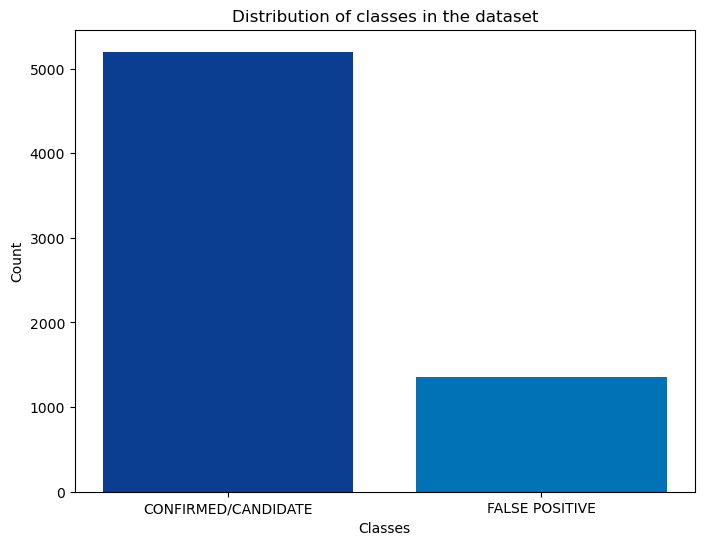

In [23]:
class_count_1, class_count_0 = plot_class_distribution(y_train)

In [24]:
print('Observations labeled 1:', class_count_1)
print('Observations labeled 0:', class_count_0)

Observations labeled 1: 5199.0
Observations labeled 0: 1355.0


In [25]:
# Save processed data
X_train.to_csv('../data/processed_data/X_tess.csv')
y_train.to_csv('../data/processed_data/y_tess.csv')

# Class weighting

The error of the minority class weighs differently

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create class weight dictionary
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

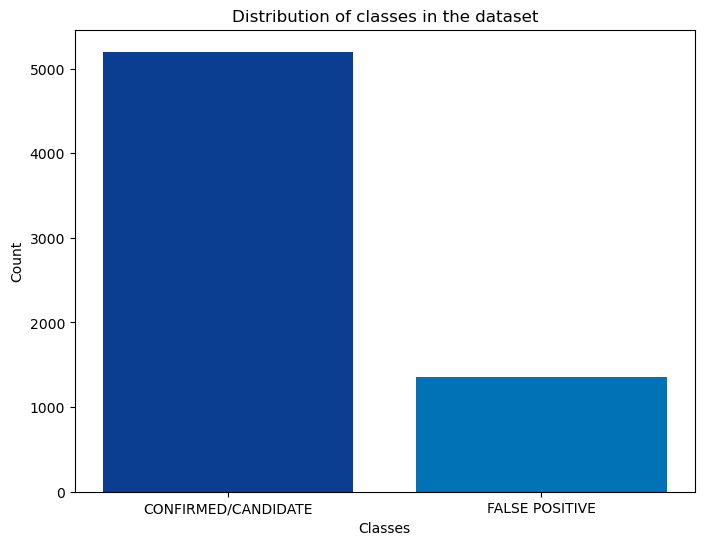

In [27]:
_, _ = plot_class_distribution(y_train)

# Train Test Split

In [28]:
TESTSET_SIZE = 0.2
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=TESTSET_SIZE, 
                                                    random_state=RANDOM_STATE, shuffle=True, stratify=None)

# Checking class distributions after the split

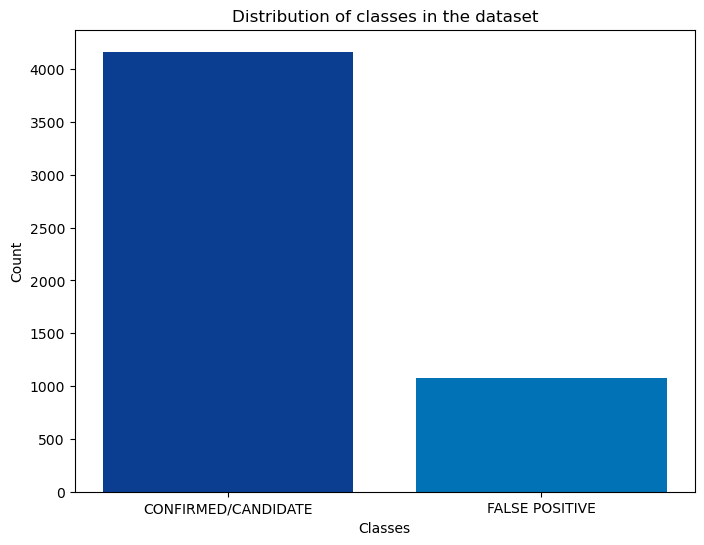

In [29]:
_, _ = plot_class_distribution(y_train)

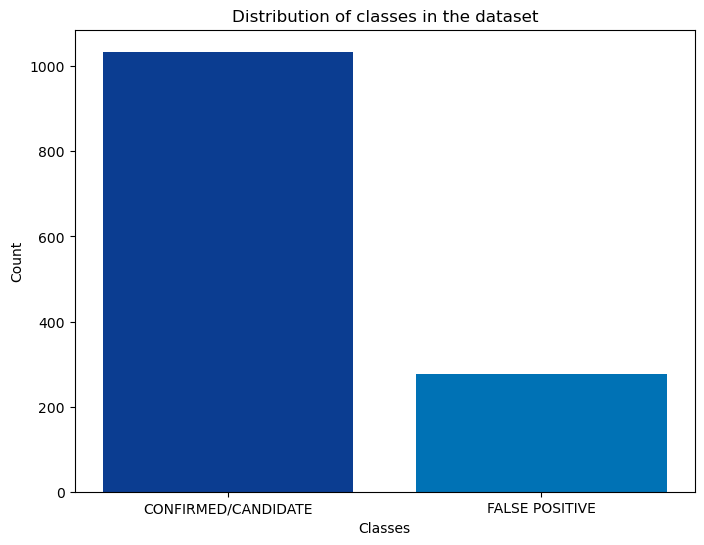

In [30]:
_, _ = plot_class_distribution(y_test)

In [31]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
print('Shape of X_test data: ', X_test.shape)
print('Shape of y_test data: ', y_test.shape)

Shape of X_train data:  (5243, 32)
Shape of y_train data:  (5243,)
Shape of X_test data:  (1311, 32)
Shape of y_test data:  (1311,)


# Grid Searh

A common method that determines optimal parameters by evaluating metrics
of the model

In [32]:
best_params, best_score, best_estimator = grid_search_param_optimization(X_train=X_train,
                                                                         y_train=y_train, n_jobs=N_JOBS)
print('Best params:', best_params)
print('Best score:', best_score)
print('Best estimator:', best_estimator)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.3s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=

In [33]:
### WITH EPOCH ###
# Best params: {'max_depth': 11, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 1000}
# Best score: 0.8482662276106373
# Best estimator: RandomForestClassifier(max_depth=11, max_features=None, n_estimators=1000)

# Best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 100}
# Best score: 0.8491334895465693
# Best estimator: RandomForestClassifier(max_features=5, n_jobs=-1)

### WITHOUT EPOCH ###
# Best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 500}
# Best score: 0.8374993632612666
# Best estimator: RandomForestClassifier(max_features=5, min_samples_split=3, n_estimators=500,
#                        n_jobs=-1)

# best_params = {}
# best_params['n_estimators'] = 100
# best_params['max_features'] = 5
# best_params['max_depth'] = None
# best_params['min_samples_split'] = 5

# Random Forest

Un classificatore di foreste casuale.

Una foresta casuale è un metastimatore che adatta una serie di classificatori dell'albero decisionale su vari sottocampioni del set di dati e utilizza la media per migliorare l'accuratezza predittiva e controllare l'adattamento eccessivo.

In [34]:
# Extracting best hyperparameters
N_ESTIMATORS = best_params['n_estimators'] # The number of trees in the forest
MAX_FEATURE = best_params['max_features'] # The number of features to consider when looking for the best split
MAX_DEPTH = best_params['max_depth'] # The maximum depth of the tree
MIN_SAMPLES_SPLIT = best_params['min_samples_split'] # Minimum number of samples required to split a node into terno
CRITERION = 'gini' # The function to measure the quality of a split

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, 
                               max_depth=MAX_DEPTH, max_features=MAX_FEATURE,
                               random_state=RANDOM_STATE, class_weight=class_weight_dict, n_jobs=N_JOBS)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0.0: 2.418450184501845,
                                     1.0: 0.6303135218311213},
                       max_features=4, n_jobs=-1, random_state=42)

$$
\text{Accuracy}: \frac{\text{true positives + true negatives}}{\text{true positives + true negatives + false positives + false negatives}}
$$ 


$$
\text{F-score}: 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

$$
\text{Precision}: \frac{\text{true positives}}{\text{true positives + false positives}}
$$


$$
\text{Recall}: \frac{\text{true positives}}{\text{true positives + false negatives}}
$$

Accuracy: 0.8268497330282227
F1-score: 0.8983430362740709
Precision: 0.8365304420350292
Recall: 0.9700193423597679


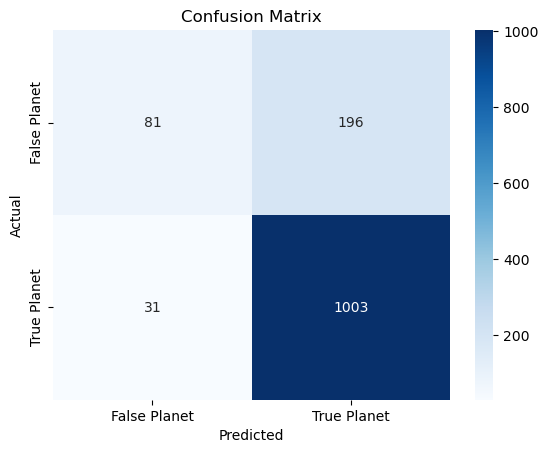

"\nN_ESTIMATORS = 100\nMAX_FEATURE = 5\nMAX_DEPTH = None\nMIN_SAMPLES_SPLIT = 5\nCRITERION = 'entropy'\nAccuracy: 83,06%\nF1-score: 90,00%\nPrecision: 84,17%\nRecall: 96,71%\ncm: [[89, 188][34, 1000]]\n"

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)

# Determine performance metrics
cm = confusion_matrix(y_test, predictions)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1-score:', f1_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
plot_confusion_matrix(cm)

"""
N_ESTIMATORS = 100
MAX_FEATURE = 5
MAX_DEPTH = None
MIN_SAMPLES_SPLIT = 5
CRITERION = 'entropy'
Accuracy: 83,06%
F1-score: 90,00%
Precision: 84,17%
Recall: 96,71%
cm: [[89, 188][34, 1000]]
"""

In [36]:
print_feature_importance(X_train=X_train, feature_importances_=model.feature_importances_)

1: TESS Mag----------------------> 0.05206397608009989
2: Planet Insolation (Earth Flux)> 0.0496709902487454
3: Planet Equil Temp (K)---------> 0.049609690836337886
4: Period (days)-----------------> 0.04700018884625345
5: Planet Radius (R_Earth) err---> 0.0434317391731748
6: Planet Radius (R_Earth)-------> 0.043012219221516705
7: Period (days) err-------------> 0.04053187069790181
8: Duration (hours)--------------> 0.04037825422117856
9: TSM---------------------------> 0.03834518895582751
10:ESM---------------------------> 0.03536664198044388
11:Stellar Radius (R_Sun)--------> 0.03340616629970875
12:Stellar Distance (pc)---------> 0.031323884286050756
13:Stellar Radius (R_Sun) err----> 0.03062994565891859
14:Depth (ppm)-------------------> 0.02992940328507854
15:Depth (mmag)------------------> 0.029920548844441695
16:Stellar Mass (M_Sun)----------> 0.02913945607592245
17:Stellar Mass (M_Sun) err------> 0.027897286687078044
18:Duration (hours) err----------> 0.026558783201547684
19:Ste

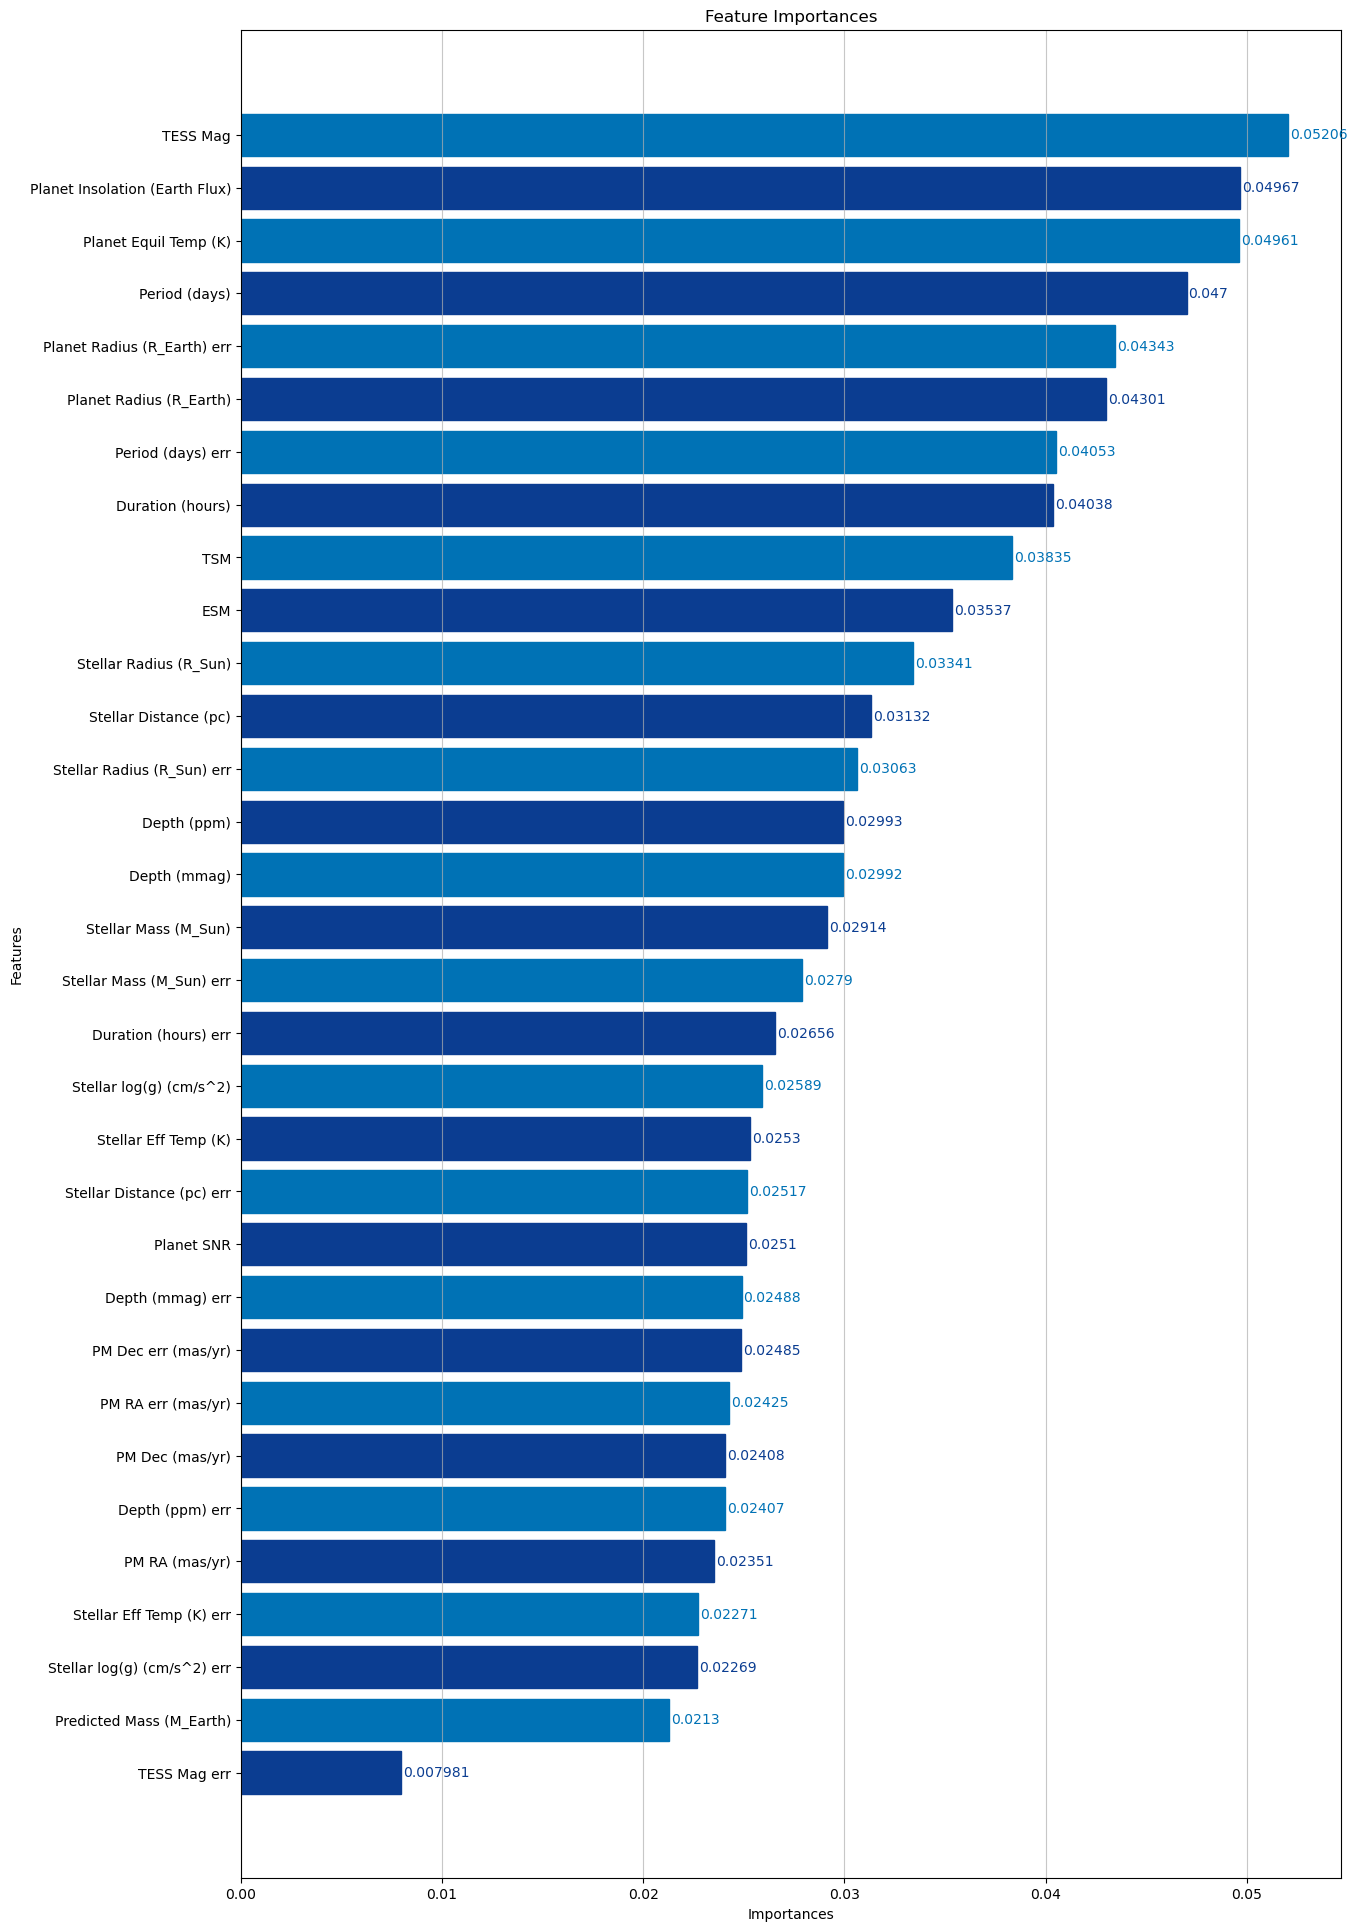

In [37]:
plot_feature_importances(X_train=X_train, feature_importances=model.feature_importances_)

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Decision Tree
dt_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10, 11]}
dt_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_classifier, dt_params, cv=5, n_jobs=N_JOBS, verbose=2)
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.2s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.3s
[CV] END ...............max_depth=None, min_samples_split=11; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.3s
[CV] END ...............max_depth=None, min_samples_split=11; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.3s
[CV] END ...............max_depth=None, min_samples_split=11; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.3s
[CV] END ...............max_depth=None, min_samp

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10, 11]},
             verbose=2)

Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.8077803203661327
F1-score: 0.883441258094357
Precision: 0.8466312056737588
Recall: 0.9235976789168279


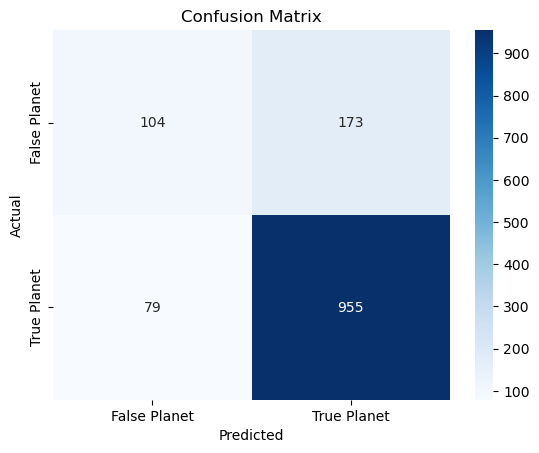

In [39]:
print("Best parameters:", dt_grid_search.best_params_)
dt_predictions = dt_grid_search.predict(X_test)
cm = confusion_matrix(y_test, dt_predictions)
print('Accuracy:', accuracy_score(y_test, dt_predictions))
print('F1-score:', f1_score(y_test, dt_predictions))
print('Precision:', precision_score(y_test, dt_predictions))
print('Recall:', recall_score(y_test, dt_predictions))
plot_confusion_matrix(cm)

# Best parameters: {'max_depth': 10, 'min_samples_split': 2}
# Accuracy: 0.8070175438596491
# F1-score: 0.883248730964467
# Precision: 0.8446601941747572
# Recall: 0.925531914893617

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn_params = {'n_neighbors': [3, 5, 7, 11, 15, 33]}
knn_classifier = KNeighborsClassifier(n_jobs=N_JOBS)
knn_grid_search = GridSearchCV(knn_classifier, knn_params, cv=5, n_jobs=N_JOBS, verbose=2)
knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END .....................................n_neighbors=11; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END .....................................n_neighbors=11; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END ......................................n_

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 11, 15, 33]}, verbose=2)

Best parameters: {'n_neighbors': 33}
Accuracy: 0.8093058733790999
F1-score: 0.8897707231040565
Precision: 0.8176661264181524
Recall: 0.9758220502901354


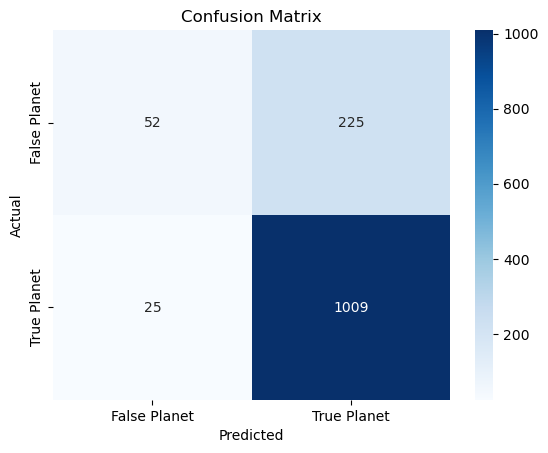

In [41]:
print("Best parameters:", knn_grid_search.best_params_)
knn_predictions = knn_grid_search.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)
print('Accuracy:', accuracy_score(y_test, knn_predictions))
print('F1-score:', f1_score(y_test, knn_predictions))
print('Precision:', precision_score(y_test, knn_predictions))
print('Recall:', recall_score(y_test, knn_predictions))
plot_confusion_matrix(cm)

# Best parameters: {'n_neighbors': 33}
# Accuracy: 0.8093058733790999
# F1-score: 0.8897707231040565
# Precision: 0.8176661264181524
# Recall: 0.9758220502901354

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb_params = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.4]}
gb_classifier = GradientBoostingClassifier()
gb_grid_search = GridSearchCV(gb_classifier, gb_params, cv=5, n_jobs=N_JOBS, verbose=2)
gb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   2.4s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   2.5s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   2.5s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   2.5s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   2.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.6s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   2.3s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.7s
[CV] END .................learning_rate=0.1, n_

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.4],
                         'n_estimators': [50, 100, 200, 500]},
             verbose=2)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 0.8093058733790999
F1-score: 0.8897707231040565
Precision: 0.8176661264181524
Recall: 0.9758220502901354


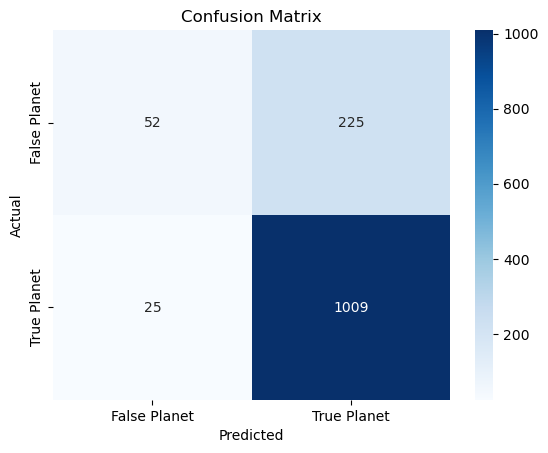

In [43]:
print("Best parameters:", gb_grid_search.best_params_)
gb_predictions = knn_grid_search.predict(X_test)
cm = confusion_matrix(y_test, gb_predictions)
print('Accuracy:', accuracy_score(y_test, gb_predictions))
print('F1-score:', f1_score(y_test, gb_predictions))
print('Precision:', precision_score(y_test, gb_predictions))
print('Recall:', recall_score(y_test, gb_predictions))
plot_confusion_matrix(cm)